In [38]:
import config
from config import *
%matplotlib inline

#Add Poisson noise random to the images and repeat the same analysis

In [39]:
class XRF_image:
    
    '''
    A class to handle XRF images obtained from X-ray flouoroscence spectra
    
    arguments:
    -----------
    
    xrf_filename: string, path to the XRF file (.h5)
    BASE_PATCH_WIDTH: int, size of the extracted cell images after padding.
    verbosity: bool, print certain parameters if needed.
    
    '''
    
    def __init__(self, xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0001_2018_1.h5',
             BASE_PATCH_WIDTH=32, verbosity=False):
        self.xrf_filename =xrf_filename
        self.BASE_PATCH_WIDTH=BASE_PATCH_WIDTH
        
        
        
    def load_xrf_data(self, hdf5_string = 'exchange_4'):
        
        '''
        
        A function to load xrf data.
        
        arguments:
        -----------
        hdf5_string: string, name of the subdirectory to extract x and y axis positions.
        
        '''
        
#         global d_Cu, d_Zn, d_Ca, d_K, d_P, d_S,d_Fe, d_Ni, d_TFY
    
        norm_ch = NORM_CH
        value_offset=VALUE_OFFSET
        xrfdata = collections.defaultdict(list)

        with h5py.File(self.xrf_filename, 'r') as dat:
            groups= list(dat.keys())
            maps= list(dat['MAPS'].keys())
            chs = dat['MAPS/channel_names'][:].astype(str).tolist()
        #         dat['MAPS/']
        #         print(chs)



            xrf = dat['MAPS/XRF_roi'][:]
        #         print(xrf)

            scaler_names = dat['MAPS/scaler_names'][:].astype(str).tolist()
            scaler_val = dat['MAPS/scalers'][:]
            norm = scaler_val[scaler_names.index(norm_ch)]
            for e in chs:
                chidx = chs.index(e)
                xrfdata[e].append(xrf[chidx]/norm)
            xrfdata['scan_num'].append(self.xrf_filename)

            hdf5_string = hdf5_string

            xrfdata['x_axis'].append(dat[hdf5_string + '/x_axis'][:])
            xrfdata['y_axis'].append(dat[hdf5_string + '/y_axis'][:])

        #         xrfdata['x_axis'].append(dat['exchange_4/x_axis'][:])
        #         xrfdata['y_axis'].append(dat['exchange_4/y_axis'][:])
        xrfdata = pd.DataFrame(xrfdata)
        #     print(xrfdata)

        elms=['Cu','Zn','Ca', 'K', 'P', 'S','Fe','Ni','TFY']#Default elms
        for i, row in xrfdata.iterrows():
                sc = row['scan_num'][0:row['scan_num'].index('.')]
                for e in elms:
                    d = row[e]

                    d[np.isnan(d) | np.isinf(d)] = 0
                    norm_d = (d - np.min(d)) / (np.max(d) - np.min(d)) + value_offset
                    ss = np.round(np.abs(np.diff(row['x_axis']))[0], 2)
                    if e == 'Cu':
                        self.d_Cu=d
                        self.norm_d_Cu=norm_d
                        x_Cu,y_Cu=row['x_axis'], row['y_axis']
                    if e == 'Zn':
                        self.d_Zn=d
                        self.norm_d_Zn=norm_d
                        x_Zn,y_Zn=row['x_axis'], row['y_axis']
                    if e == 'Ca':
                        self.d_Ca=d
                        self.norm_d_Ca=norm_d
                        x_Ca,y_Ca=row['x_axis'], row['y_axis']
                    if e == 'K':
                        self.d_K=d
                        self.norm_d_K=norm_d
                        x_K,y_K=row['x_axis'], row['y_axis']
                    if e == 'P':
                        self.d_P=d
                        self.norm_d_P=norm_d
                        x_P,y_P=row['x_axis'], row['y_axis']
                    if e == 'S':
                        self.d_S=d
                        self.norm_d_S=norm_d
                        x_S,y_S=row['x_axis'], row['y_axis']

                    if e == 'Fe':
                        self.d_Fe=d
                        self.norm_d_Fe=norm_d
                        x_Fe,y_Fe=row['x_axis'], row['y_axis']

                    if e == 'Ni':
                        self.d_Ni=d
                        self.norm_d_Ni=norm_d
                        x_Ni,y_Ni=row['x_axis'], row['y_axis']

                    if e == 'TFY':
                        self.d_TFY=d
                        self.norm_d_TFY=norm_d
                        x_TFY,y_TFY=row['x_axis'], row['y_axis']
        #     print('Image shape: ',d.shape)
        
                    
    

        
    
    
    def binary_conversion(self, e='Cu'):
        '''
        A function to convert the elemental channel images to binary image.
        
        
        arugments:
        ----------
        
        e: string, name of the elemental channel to use for binary conversion.
        
        '''
        #choose elemental channel for conversion
        
        if e == 'Cu':
            data_original = self.d_Cu
            
        if e == 'Zn':
            data_original = self.d_Zn
            
        if e == 'Ca':
            data_original = self.d_Ca
            
        if e == 'K':
            data_original = self.d_K
            
        if e == 'P':
            data_original = self.d_P
            
        if e == 'S':
            data_original = self.d_S
            

        if e == 'Fe':
            data_original = self.d_Fe
            

        if e == 'Ni':
            data_original = self.d_Ni
            
        if e == 'TFY':
            data_original = self.d_TFY
            
#         data_original=d_Cu
        data=data_original
        data = ndimage.median_filter(data, size=3)


        thresh = 1.5*threshold_otsu(data)
        binary = data < thresh
        binary = binary^1


        binary_eroded=ndimage.binary_erosion(binary).astype(binary.dtype)
        binary_dilated=ndimage.binary_dilation(binary).astype(binary.dtype)
        self.binary_ero_dil=ndimage.binary_dilation(binary_eroded).astype(binary_eroded.dtype)
        
        self.labeled_array, self.num_features = label(self.binary_ero_dil)
        
    def extract_cells(self):
        
        '''
        A function to extract the cells from binary image and convert them to images and features.
        '''
        
        self.regions = measure.regionprops(self.labeled_array)    
        # print(len(regions))

        self.cell_list = []
        self.center_list = []
        self.Patches_Cu = []
        self.Patches_Zn = []
        self.Patches_Ca = []
        self.Patches_K = []
        self.Patches_P = []
        self.Patches_S = []
        self.Patches_Fe = []
        self.Patches_Ni = []
        self.Patches_TFY= []
        self.binary_img=[]
        self.region_vals=[]
        self.features_list = []
        self.center_coords=[]
        self.XRF_track_files=[]

        for idx in range(len(self.regions)):
            self.cell_val_bin=self.regions[idx].image
            self.center_coords.append(self.regions[idx].centroid)
            self.XRF_track_files.append(self.xrf_filename)
            self.region_vals.append(self.cell_val_bin)
            self.padded_cell = np.pad(self.cell_val_bin, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.cell_list.append(self.padded_cell)
            self.center_list.append([math.floor(self.regions[idx].centroid[0]), math.floor(self.regions[idx].centroid[1])])
        #     regions[idx].bbox

            self.cell_Cu = self.d_Cu[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_Zn = self.d_Zn[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_Ca = self.d_Ca[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_K = self.d_K[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_P = self.d_P[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_S = self.d_S[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_Fe = self.d_Fe[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_Ni = self.d_Ni[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_TFY = self.d_TFY[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]

            self.padded_bin = np.pad(self.cell_val_bin, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_Cu = np.pad(self.cell_Cu, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_Zn = np.pad(self.cell_Cu, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_Ca = np.pad(self.cell_Cu, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_K = np.pad(self.cell_K, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_P = np.pad(self.cell_P, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_S = np.pad(self.cell_S, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_Fe = np.pad(self.cell_Fe, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_Ni = np.pad(self.cell_Ni, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_TFY = np.pad(self.cell_TFY, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))

            self.binary_img.append(self.padded_bin)
            self.Patches_Cu.append(self.padded_Cu)
            self.Patches_Zn.append(self.padded_Zn)
            self.Patches_Ca.append(self.padded_Ca)
            self.Patches_K.append(self.padded_K)
            self.Patches_P.append(self.padded_P)
            self.Patches_S.append(self.padded_S)
            self.Patches_Fe.append(self.padded_Fe)
            self.Patches_Ni.append(self.padded_Ni)
            self.Patches_TFY.append(self.padded_TFY)


            # define feature vector using averages
        #     x = np.asarray([regions[idx].area, 
        #      regions[idx].eccentricity, 
        #      regions[idx].equivalent_diameter, 
        #      regions[idx].major_axis_length,
        #      regions[idx].minor_axis_length,
        #      regions[idx].perimeter,
        #      np.average(Patches_K[idx]),
        #      np.average(Patches_K[idx])/np.average(Patches_P[idx]),
        #      np.average(Patches_Ni[idx]),
        #      np.average(Patches_Ni[idx])/np.average(Patches_P[idx]),
        #     np.average(Patches_Ni[idx])/np.average(Patches_K[idx]),
        #     np.average(Patches_Cu[idx])/np.average(Patches_K[idx]),
        #     ])

            # define feature vector using averages
            self.x = np.asarray([0.25*0.25*self.regions[idx].area, 
             self.regions[idx].eccentricity, 
             0.25*self.regions[idx].equivalent_diameter, 
             0.25*self.regions[idx].major_axis_length,
             0.25*self.regions[idx].minor_axis_length,
             0.25*self.regions[idx].perimeter,
             np.amax(self.Patches_K[idx]),
             np.amax(self.Patches_P[idx]),
             np.amax(self.Patches_Ni[idx]),
             np.amax(self.Patches_Zn[idx]),
            np.amax(self.Patches_Fe[idx]),
            np.amax(self.Patches_Cu[idx]),
            np.amax(self.Patches_TFY[idx]-self.Patches_K[idx]-self.Patches_P[idx]-self.Patches_Ni[idx]-self.Patches_Zn[idx]-self.Patches_Fe[idx]-self.Patches_Cu[idx]),
            np.unique(x.region_vals[idx], return_counts=True)[1][1] # returns the number of true (1's) values in the identified region
            ])

            self.features_list.append(self.x)
        self.features=np.asarray(self.features_list)

    def add_noise(self, noise='poisson'):
        
        '''
        
        A function to add noise once the data is loaded and binary conversion and extraction is done.
        
        arguments:
        -----------
        noise: string, depending on types of noise. 'none' indicates no noise to be added.
        
        '''
        
        self.noise=noise
        if self.noise == 'poisson':
            k=0.05
            np.random.seed(0)
            self.normal_noise=abs(np.random.normal(k, math.sqrt(k), self.d_Cu.shape))
            self.d_Cu = self.d_Cu*(1+self.normal_noise) 
            self.d_Zn = self.d_Zn*(1+self.normal_noise)
            self.d_Ca = self.d_Ca*(1+self.normal_noise)
            self.d_K = self.d_K*(1+self.normal_noise)
            self.d_P = self.d_P*(1+self.normal_noise)
            self.d_S = self.d_S*(1+self.normal_noise)
            self.d_Fe = self.d_Fe*(1+self.normal_noise)
            self.d_Ni = self.d_Ni*(1+self.normal_noise)
            self.d_TFY = self.d_TFY*(1+self.normal_noise)
            

In [40]:
def calc_SNR(img, seg_img, labels = (0,1), mask_ratio = None):
    """
    SNR =  1     /  s*sqrt(std0^^2 + std1^^2)  
    where s = 1 / (mu1 - mu0)  
    mu1, std1 and mu0, std0 are the mean / std values for each of the segmented regions respectively (pix value = 1) and (pix value = 0).  
    seg_img is used as mask to determine stats in each region.  
    Parameters
    ----------
    img : np.array  
        raw input image (2D or 3D)  
    
    seg_img : np.array  
        segmentation map (2D or 3D)  
        
    labels : tuple  
        an ordered list of two label values in the image. The high value is interpreted as the signal and low value is the background.  
        
    mask_ratio : float or None
        If not None, a float in (0,1). The data are cropped such that the voxels / pixels outside the circular mask are ignored.  
    Returns
    -------
    float
        SNR of img w.r.t seg_img  
    """
    eps = 1.0e-12
    # handle circular mask  
    if mask_ratio is not None:
        crop_val = int(img.shape[-1]*0.5*(1 - mask_ratio/np.sqrt(2)))
        crop_slice = slice(crop_val, -crop_val)    

        if img.ndim == 2: # 2D image
            img = img[crop_slice, crop_slice]
            seg_img = seg_img[crop_slice, crop_slice]
        elif img.ndim == 3: # 3D image
            vcrop = int(img.shape[0]*(1-mask_ratio))
            vcrop_slice = slice(vcrop, -vcrop)
            img = img[vcrop_slice, crop_slice, crop_slice]
            seg_img = seg_img[vcrop_slice, crop_slice, crop_slice]
            
    pix_1 = img[seg_img == labels[1]]
    pix_0 = img[seg_img == labels[0]]
    
    if np.any(pix_1) and np.any(pix_0):
        mu1 = np.mean(pix_1)
        mu0 = np.mean(pix_0)
        s = abs(1/(mu1 - mu0 + eps))
        std1 = np.std(pix_1)
        std0 = np.std(pix_0)
        std = np.sqrt(0.5*(std1**2 + std0**2))
        std = s*std
        return 1/(std + eps)
    else:
        return 1/(np.std(img) + eps)

In [41]:
noise_type = 'none'

In [42]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0001_2018_1.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.add_noise(noise=noise_type)

x.binary_conversion(e='Cu')
x.extract_cells()
X_bin1=x.binary_img  

X_Cu1=x.Patches_Cu
X_Zn1=x.Patches_Zn
X_Ca1=x.Patches_Ca
X_K1=x.Patches_K
X_P1=x.Patches_P
X_S1=x.Patches_S
X_Fe1=x.Patches_Fe
X_Ni1=x.Patches_Ni
X_TFY1=x.Patches_TFY

SNR_X1=calc_SNR(x.d_Cu, x.binary_ero_dil)

X1=x.features


X_centers1=x.center_coords
X_xrf_track_file1=x.XRF_track_files

X1.shape

(110, 14)

In [43]:
X_xrf_track_file1

['/data01/AZC/XRF_Data/bnp_fly0001_2018_1.h5',
 '/data01/AZC/XRF_Data/bnp_fly0001_2018_1.h5',
 '/data01/AZC/XRF_Data/bnp_fly0001_2018_1.h5',
 '/data01/AZC/XRF_Data/bnp_fly0001_2018_1.h5',
 '/data01/AZC/XRF_Data/bnp_fly0001_2018_1.h5',
 '/data01/AZC/XRF_Data/bnp_fly0001_2018_1.h5',
 '/data01/AZC/XRF_Data/bnp_fly0001_2018_1.h5',
 '/data01/AZC/XRF_Data/bnp_fly0001_2018_1.h5',
 '/data01/AZC/XRF_Data/bnp_fly0001_2018_1.h5',
 '/data01/AZC/XRF_Data/bnp_fly0001_2018_1.h5',
 '/data01/AZC/XRF_Data/bnp_fly0001_2018_1.h5',
 '/data01/AZC/XRF_Data/bnp_fly0001_2018_1.h5',
 '/data01/AZC/XRF_Data/bnp_fly0001_2018_1.h5',
 '/data01/AZC/XRF_Data/bnp_fly0001_2018_1.h5',
 '/data01/AZC/XRF_Data/bnp_fly0001_2018_1.h5',
 '/data01/AZC/XRF_Data/bnp_fly0001_2018_1.h5',
 '/data01/AZC/XRF_Data/bnp_fly0001_2018_1.h5',
 '/data01/AZC/XRF_Data/bnp_fly0001_2018_1.h5',
 '/data01/AZC/XRF_Data/bnp_fly0001_2018_1.h5',
 '/data01/AZC/XRF_Data/bnp_fly0001_2018_1.h5',
 '/data01/AZC/XRF_Data/bnp_fly0001_2018_1.h5',
 '/data01/AZC

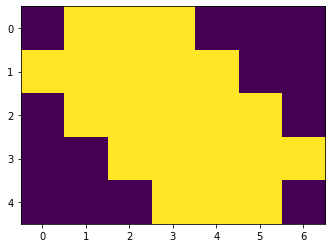

In [44]:
plt.imshow(x.region_vals[3])

In [45]:
x.regions[109].centroid

(251.0, 174.5)

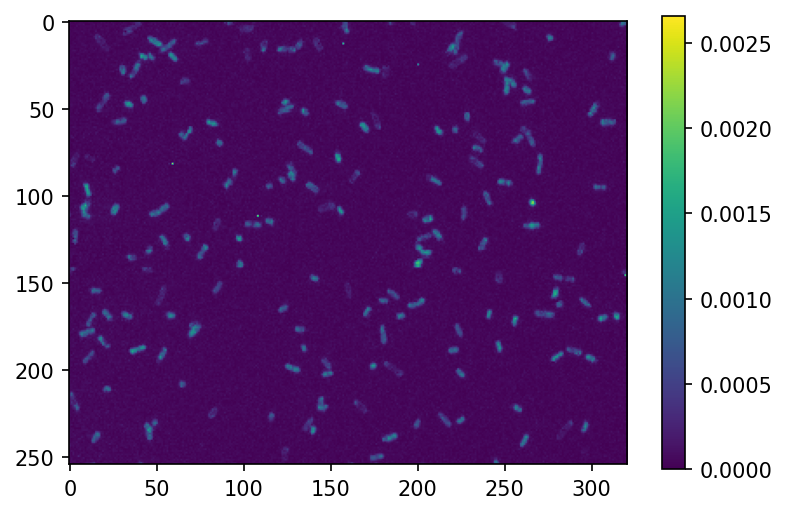

In [46]:
x.noise
plt.figure(dpi=150)
plt.imshow(x.d_Cu)
plt.colorbar()

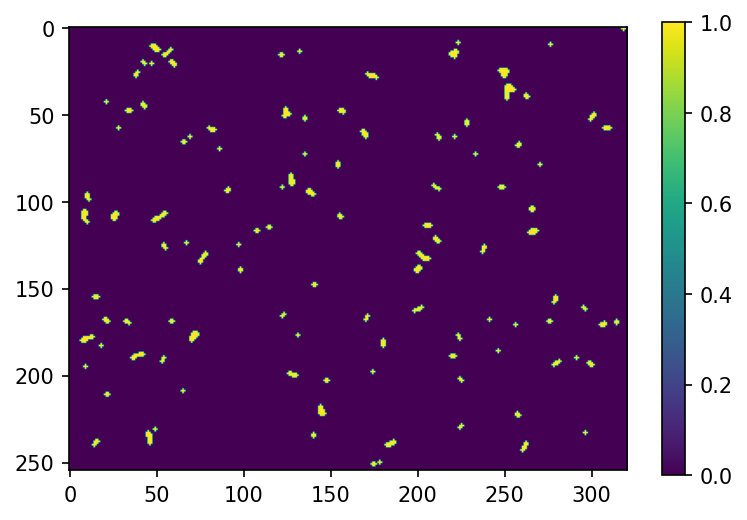

In [47]:
x.noise
plt.figure(dpi=150)
plt.imshow(x.binary_ero_dil)
plt.colorbar()

In [48]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0001_2018_3.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.add_noise(noise=noise_type)
x.binary_conversion(e='K')
x.extract_cells()
X_bin2=x.binary_img
           
X_Cu2=x.Patches_Cu
X_Zn2=x.Patches_Zn
X_Ca2=x.Patches_Ca
X_K2=x.Patches_K
X_P2=x.Patches_P
X_S2=x.Patches_S
X_Fe2=x.Patches_Fe
X_Ni2=x.Patches_Ni
X_TFY2=x.Patches_TFY


SNR_X2=calc_SNR(x.d_K, x.binary_ero_dil)

X2=x.features


X_centers2=x.center_coords
X_xrf_track_file2=x.XRF_track_files

X2.shape

(41, 14)

In [49]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0003_2018_3.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.add_noise(noise=noise_type)

x.binary_conversion(e='K')
x.extract_cells()
X_bin3=x.binary_img

X_Cu3=x.Patches_Cu
X_Zn3=x.Patches_Zn
X_Ca3=x.Patches_Ca
X_K3=x.Patches_K
X_P3=x.Patches_P
X_S3=x.Patches_S
X_Fe3=x.Patches_Fe
X_Ni3=x.Patches_Ni
X_TFY3=x.Patches_TFY


SNR_X3=calc_SNR(x.d_K, x.binary_ero_dil)

X3=x.features


X_centers3=x.center_coords
X_xrf_track_file3=x.XRF_track_files

X3.shape

(43, 14)

In [50]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0012_2018_1w2.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.add_noise(noise=noise_type)

x.binary_conversion(e='Cu')
x.extract_cells()
X_bin4=x.binary_img

X_Cu4=x.Patches_Cu
X_Zn4=x.Patches_Zn
X_Ca4=x.Patches_Ca
X_K4=x.Patches_K
X_P4=x.Patches_P
X_S4=x.Patches_S
X_Fe4=x.Patches_Fe
X_Ni4=x.Patches_Ni
X_TFY4=x.Patches_TFY

SNR_X4=calc_SNR(x.d_Cu, x.binary_ero_dil)

X4=x.features


X_centers4=x.center_coords
X_xrf_track_file4=x.XRF_track_files

X4.shape

(53, 14)

In [51]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0014_2018_1w2.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.add_noise(noise=noise_type)

x.binary_conversion(e='Cu')
x.extract_cells()

X_bin5=x.binary_img

X_Cu5=x.Patches_Cu
X_Zn5=x.Patches_Zn
X_Ca5=x.Patches_Ca
X_K5=x.Patches_K
X_P5=x.Patches_P
X_S5=x.Patches_S
X_Fe5=x.Patches_Fe
X_Ni5=x.Patches_Ni
X_TFY5=x.Patches_TFY

SNR_X5=calc_SNR(x.d_Cu, x.binary_ero_dil)


X5=x.features


X_centers5=x.center_coords
X_xrf_track_file5=x.XRF_track_files

X5.shape

(55, 14)

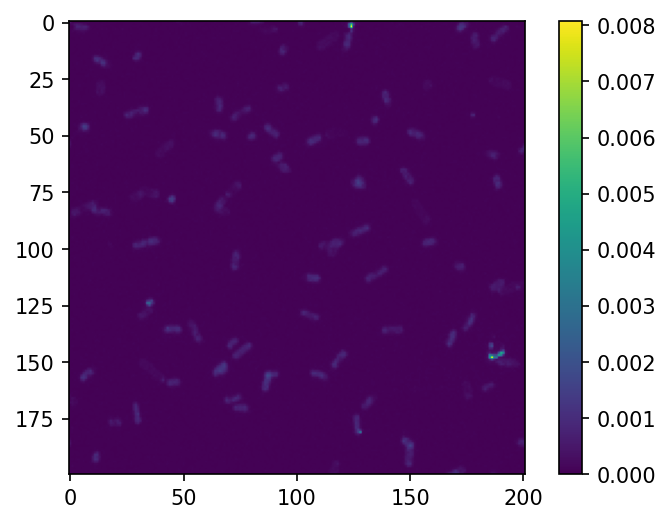

In [52]:
plt.figure(dpi=150)
plt.imshow(x.d_Cu)
plt.colorbar()

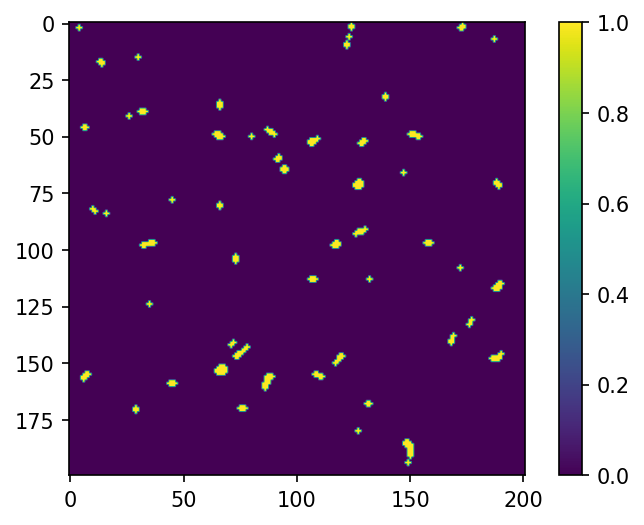

In [53]:
plt.figure(dpi=150)
plt.imshow(x.binary_ero_dil)
plt.colorbar()

In [54]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0040_2018_1.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.add_noise(noise=noise_type)

x.binary_conversion(e='Cu')
x.extract_cells()
X_bin6=x.binary_img

X_Cu6=x.Patches_Cu
X_Zn6=x.Patches_Zn
X_Ca6=x.Patches_Ca
X_K6=x.Patches_K
X_P6=x.Patches_P
X_S6=x.Patches_S
X_Fe6=x.Patches_Fe
X_Ni6=x.Patches_Ni
X_TFY6=x.Patches_TFY

SNR_X6=calc_SNR(x.d_Cu, x.binary_ero_dil)

X6=x.features


X_centers6=x.center_coords
X_xrf_track_file6=x.XRF_track_files

X6.shape

(39, 14)

In [55]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0050_2018_1.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.add_noise(noise=noise_type)

x.binary_conversion(e='Cu')
x.extract_cells()
X_bin7=x.binary_img

X_Cu7=x.Patches_Cu
X_Zn7=x.Patches_Zn
X_Ca7=x.Patches_Ca
X_K7=x.Patches_K
X_P7=x.Patches_P
X_S7=x.Patches_S
X_Fe7=x.Patches_Fe
X_Ni7=x.Patches_Ni
X_TFY7=x.Patches_TFY

SNR_X7=calc_SNR(x.d_Cu, x.binary_ero_dil)

X7=x.features


X_centers7=x.center_coords
X_xrf_track_file7=x.XRF_track_files

X7.shape

(57, 14)

In [56]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0051_2018_1.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.add_noise(noise=noise_type)

x.binary_conversion(e='Cu')
x.extract_cells()
X_bin8=x.binary_img


X_Cu8=x.Patches_Cu
X_Zn8=x.Patches_Zn
X_Ca8=x.Patches_Ca
X_K8=x.Patches_K
X_P8=x.Patches_P
X_S8=x.Patches_S
X_Fe8=x.Patches_Fe
X_Ni8=x.Patches_Ni
X_TFY8=x.Patches_TFY

SNR_X8=calc_SNR(x.d_Cu, x.binary_ero_dil)

X8=x.features


X_centers8=x.center_coords
X_xrf_track_file8=x.XRF_track_files

X8.shape

(61, 14)

In [57]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0052_2018_1.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.add_noise(noise=noise_type)

x.binary_conversion(e='Cu')
x.extract_cells()
X_bin9=x.binary_img

X_Cu9=x.Patches_Cu
X_Zn9=x.Patches_Zn
X_Ca9=x.Patches_Ca
X_K9=x.Patches_K
X_P9=x.Patches_P
X_S9=x.Patches_S
X_Fe9=x.Patches_Fe
X_Ni9=x.Patches_Ni
X_TFY9=x.Patches_TFY

SNR_X9=calc_SNR(x.d_Cu, x.binary_ero_dil)

X9=x.features


X_centers9=x.center_coords
X_xrf_track_file9=x.XRF_track_files

X9.shape

(31, 14)

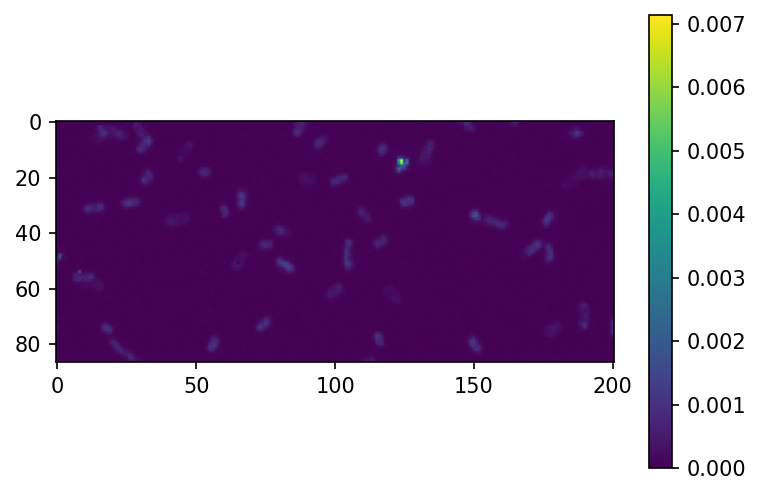

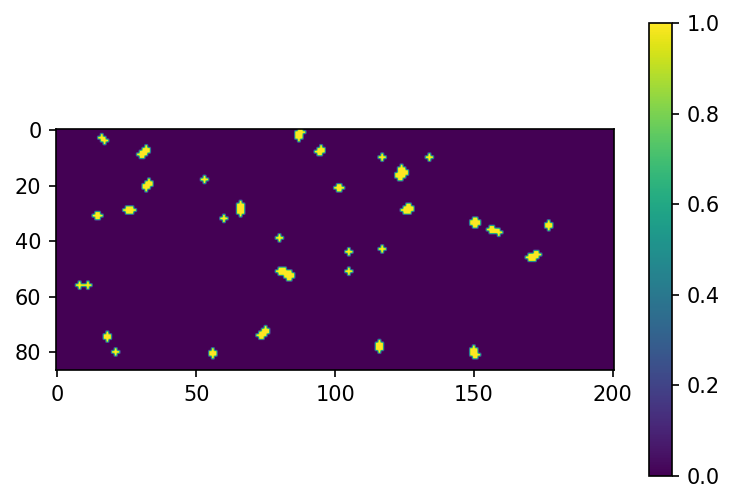

In [58]:
plt.figure(dpi=150)
plt.imshow(x.d_Cu)
plt.colorbar()
plt.figure(dpi=150)
plt.imshow(x.binary_ero_dil)
plt.colorbar()

In [59]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0065_2018_3.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.add_noise(noise=noise_type)
x.binary_conversion(e='K')
x.extract_cells()
X_bin10=x.binary_img

X_Cu10=x.Patches_Cu
X_Zn10=x.Patches_Zn
X_Ca10=x.Patches_Ca
X_K10=x.Patches_K
X_P10=x.Patches_P
X_S10=x.Patches_S
X_Fe10=x.Patches_Fe
X_Ni10=x.Patches_Ni
X_TFY10=x.Patches_TFY


SNR_X10=calc_SNR(x.d_K, x.binary_ero_dil)

X10=x.features


X_centers10=x.center_coords
X_xrf_track_file10=x.XRF_track_files

X10.shape

(64, 14)

In [60]:
SNR_X5

1.6935878936935345

In [65]:
X=np.concatenate((X1,X2,X3,X4,X5,X6,X7,X8,X9,X10))
X_bin=np.concatenate((X_bin1,X_bin2,X_bin3,X_bin4,X_bin5,X_bin6,X_bin7,X_bin8,X_bin9,X_bin10))
X_Cu=np.concatenate((X_Cu1,X_Cu2,X_Cu3,X_Cu4,X_Cu5,X_Cu6,X_Cu7,X_Cu8,X_Cu9,X_Cu10))
X_Zn=np.concatenate((X_Zn1,X_Zn2,X_Zn3,X_Zn4,X_Zn5,X_Zn6,X_Zn7,X_Zn8,X_Zn9,X_Zn10))
X_Ca=np.concatenate((X_Ca1,X_Ca2,X_Ca3,X_Ca4,X_Ca5,X_Ca6,X_Ca7,X_Ca8,X_Ca9,X_Ca10))
X_K=np.concatenate((X_K1,X_K2,X_K3,X_K4,X_K5,X_K6,X_K7,X_K8,X_K9,X_K10))
X_P=np.concatenate((X_P1,X_P2,X_P3,X_P4,X_P5,X_P6,X_P7,X_P8,X_P9,X_P10))
X_S=np.concatenate((X_S1,X_S2,X_S3,X_S4,X_S5,X_S6,X_S7,X_S8,X_S9,X_S10))
X_Fe=np.concatenate((X_Fe1,X_Fe2,X_Fe3,X_Fe4,X_Fe5,X_Fe6,X_Fe7,X_Fe8,X_Fe9,X_Fe10))
X_Ni=np.concatenate((X_Ni1,X_Ni2,X_Ni3,X_Ni4,X_Ni5,X_Ni6,X_Ni7,X_Ni8,X_Ni9,X_Ni10))
X_TFY=np.concatenate((X_TFY1,X_TFY2,X_TFY3,X_TFY4,X_TFY5,X_TFY6,X_TFY7,X_TFY8,X_TFY9,X_TFY10))

SNR=np.array([SNR_X1,SNR_X2,SNR_X3,SNR_X4,SNR_X5,SNR_X6,SNR_X7,SNR_X8,SNR_X9,SNR_X10])
SNR_Df = pd.DataFrame()
SNR_Df['SNR']=SNR

X_centers=np.concatenate((X_centers1,X_centers2,X_centers3,X_centers4,X_centers5,X_centers6,X_centers7,X_centers8,X_centers9,X_centers10))

X_xrf_track_files=np.concatenate((X_xrf_track_file1,X_xrf_track_file2,X_xrf_track_file3,X_xrf_track_file4,X_xrf_track_file5,
                  X_xrf_track_file6,X_xrf_track_file7,X_xrf_track_file8,X_xrf_track_file9,X_xrf_track_file10))



In [66]:
print(SNR_Df.to_string())

        SNR
0  3.880045
1  2.631588
2  3.528444
3  3.898880
4  1.693588
5  3.403694
6  3.785310
7  3.921183
8  1.768227
9  3.176243


In [67]:
print(X.shape)
print(X_bin.shape)

(554, 14)
(554, 32, 32)


In [68]:
linethresh_val=0.00001
resolution=DEFAULT_RESOLUTION_CELL

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors

def viewer(idx):

    fig = plt.figure(figsize=(10, 20))
    fig.suptitle('cell_img'+ '_' + str(idx))

    ax1 = fig.add_subplot(521)
    ax1.set_title('binary'+ '_' + str(idx))
    im1 = ax1.imshow(X_bin[idx].T, interpolation='none')
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')
    scalebar_master = ScaleBar( SCALE_UNIT_FACTOR*resolution, "m", color='white', length_fraction=0.10, box_alpha=0.10)
    ax1.add_artist(scalebar_master)
    
    

    ax2 = fig.add_subplot(522)
    ax2.set_title('Cu')
    im2 = ax2.imshow(X_Cu[idx].T, interpolation='none', vmax=0.003087)
#     im2 = ax2.imshow(X_Cu[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical');


    ax3 = fig.add_subplot(523)
    ax3.set_title('Zn')
    im3 = ax3.imshow(X_Zn[idx].T, interpolation='none', vmax=0.00318)
#     im3 = ax3.imshow(X_Zn[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im3, cax=cax, orientation='vertical');

    ax4 = fig.add_subplot(524)
    ax4.set_title('Ca')
    im4 = ax4.imshow(X_Ca[idx].T, interpolation='none', vmax=0.00174)
#     im4 = ax4.imshow(X_Ca[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val) )
    divider = make_axes_locatable(ax4)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im4, cax=cax, orientation='vertical');


    ax5 = fig.add_subplot(525)
    ax5.set_title('K')
    im5 = ax5.imshow(X_K[idx].T, interpolation='none',vmax=0.000584)
#     im5 = ax5.imshow(X_K[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax5)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im5, cax=cax, orientation='vertical');

    ax6 = fig.add_subplot(526)
    ax6.set_title('P')
    im6 = ax6.imshow(X_P[idx].T, interpolation='none', vmax=0.000164)
#     im6 = ax6.imshow(X_P[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax6)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im6, cax=cax, orientation='vertical');

    ax7 = fig.add_subplot(527)
    ax7.set_title('S')
    im7 = ax7.imshow(X_S[idx].T, interpolation='none', vmax=0.000122)
#     im7 = ax7.imshow(X_S[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax7)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im7, cax=cax, orientation='vertical');

    ax8 = fig.add_subplot(528)
    ax8.set_title('Ni')
    im8 = ax8.imshow(X_Ni[idx].T, interpolation='none', vmax=0.000093)
#     im8 = ax8.imshow(X_Ni[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax8)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im8, cax=cax, orientation='vertical');

    ax9 = fig.add_subplot(529)
    ax9.set_title('Fe')
    im9 = ax9.imshow(X_Fe[idx].T, interpolation='none', vmax=0.000139)
#     im9 = ax9.imshow(X_Fe[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax9)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im9, cax=cax, orientation='vertical');

    ax10 = fig.add_subplot(5,2,10)
    ax10.set_title('TFY')
    im10 = ax10.imshow(X_TFY[idx].T, interpolation='none', vmax=0.029495)
#     im10 = ax10.imshow(X_TFY[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = 500*linethresh_val))
    divider = make_axes_locatable(ax10)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im10, cax=cax, orientation='vertical');


interactive_plot = interactive(viewer, idx=(0, len(X_bin)-1))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=276, description='idx', max=553), Output()), _dom_classes=('widget-inter…

In [69]:
#create the dataframe

principalDf = pd.DataFrame(
             columns = ['Pixel_count', 'area'])

principalDf['area'] = X[:,0]
principalDf['eccentricity'] = X[:,1]
principalDf['equivalent_diameter'] = X[:,2]
principalDf['major_axis_length'] = X[:,3]
principalDf['minor_axis_length'] = X[:,4]
principalDf['perimeter'] = X[:,5]
principalDf['K'] = X[:,6]
principalDf['P'] = X[:,7]
principalDf['Ni'] = X[:,8]
principalDf['Zn'] = X[:,9]
principalDf['Fe'] = X[:,10]
principalDf['Cu'] = X[:,11]
principalDf['BFY'] = X[:,12]
principalDf['Pixel_count'] = X[:,13].astype(int)

In [70]:
#add Kiwon's labels
#import annotations for all 554 images.
KO_annotations = pd.read_csv('xrf_annotations_arshad_KO_full_indices.csv')
principalDf['KO_label']=KO_annotations['KO_label'].to_numpy()
principalDf['K_obs_labels']=KO_annotations['K'].to_numpy()
principalDf['Ni_obs_labels']=KO_annotations['Ni'].to_numpy()
principalDf['Fe_obs_labels']=KO_annotations['Fe'].to_numpy()
principalDf['Cu_obs_labels']=KO_annotations['Cu'].to_numpy()
principalDf['Ca_obs_labels']=KO_annotations['Ca'].to_numpy()
principalDf['Zn_obs_labels']=KO_annotations['Zn'].to_numpy()

principalDf.KO_label = principalDf.KO_label.fillna('not_annotated')
principalDf.K_obs_labels = principalDf.K_obs_labels.fillna('not_annotated')
principalDf.Ni_obs_labels = principalDf.Ni_obs_labels.fillna('not_annotated')
principalDf.Fe_obs_labels = principalDf.Fe_obs_labels.fillna('not_annotated')
principalDf.Cu_obs_labels = principalDf.Cu_obs_labels.fillna('not_annotated')
principalDf.Ca_obs_labels = principalDf.Ca_obs_labels.fillna('not_annotated')
principalDf.Zn_obs_labels = principalDf.Zn_obs_labels.fillna('not_annotated')

In [71]:
KO_annotations

,original indices,KO_label,live,dead,K,Ni,Fe,Cu,Ca,Zn,number of cells
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,dead,NaN,v,low,high,high,high,high,high,1.0
4,4,dead,NaN,v,low,high,high,mid,high,high,1.0
...,...,...,...,...,...,...,...,...,...,...,...
549,549,live,v,NaN,high,low,low,low,low,low,1.0
550,550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
551,551,live,v,NaN,high,low,low,low,low,low,1.0
552,552,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
principalDf

,Pixel_count,area,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,perimeter,K,P,Ni,...,Fe,Cu,BFY,KO_label,K_obs_labels,Ni_obs_labels,Fe_obs_labels,Cu_obs_labels,Ca_obs_labels,Zn_obs_labels
0,5,0.3125,0.000000,0.630783,0.632456,0.632456,1.414214,0.000029,0.000030,0.000029,...,0.000071,0.001002,0.015246,not_annotated,not_annotated,not_annotated,not_annotated,not_annotated,not_annotated,not_annotated
1,5,0.3125,0.000000,0.630783,0.632456,0.632456,1.414214,0.000029,0.000030,0.000043,...,0.000062,0.000768,0.015790,not_annotated,not_annotated,not_annotated,not_annotated,not_annotated,not_annotated,not_annotated
2,5,0.3125,0.000000,0.630783,0.632456,0.632456,1.414214,0.000030,0.000045,0.000043,...,0.000095,0.001093,0.018312,not_annotated,not_annotated,not_annotated,not_annotated,not_annotated,not_annotated,not_annotated
3,21,1.3125,0.846038,1.292721,1.764861,0.940886,3.828427,0.000045,0.000083,0.000058,...,0.000059,0.001371,0.016610,dead,low,high,high,high,high,high
4,17,1.0625,0.945978,1.163107,2.102629,0.681738,2.267767,0.000045,0.000041,0.000055,...,0.000076,0.001019,0.017674,dead,low,high,high,mid,high,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549,25,1.5625,0.941817,1.410474,2.474690,0.831810,5.035534,0.000437,0.000122,0.000056,...,0.000095,0.000059,0.005291,live,high,low,low,low,low,low
550,66,4.1250,0.780748,2.291749,3.971010,2.481270,10.321068,0.000446,0.000147,0.000066,...,0.000125,0.000099,0.005216,not_annotated,not_annotated,not_annotated,not_annotated,not_annotated,not_annotated,not_annotated
551,11,0.6875,0.819334,0.935603,1.241999,0.712058,2.267767,0.000449,0.000102,0.000034,...,0.000068,0.000064,0.004908,live,high,low,low,low,low,low
552,5,0.3125,0.000000,0.630783,0.632456,0.632456,1.414214,0.000313,0.000101,0.000029,...,0.000116,0.000031,0.004815,not_annotated,not_annotated,not_annotated,not_annotated,not_annotated,not_annotated,not_annotated


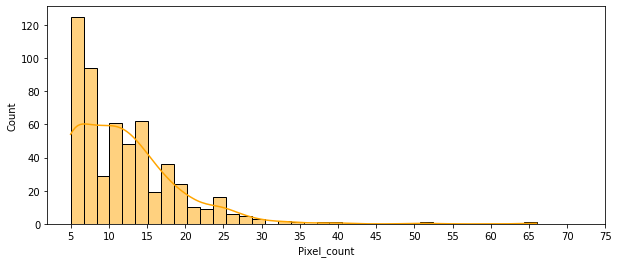

In [73]:
fig = plt.figure(figsize=(10, 4))
ss_plot=sns.histplot(data=principalDf, x="Pixel_count", kde=True,color='orange')
plt.xticks([5,10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60,65,70,75]);


In [74]:


# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     display(principalDf[principalDf['Pixel_count']==10])
principalDf[principalDf['Pixel_count']==8]

,Pixel_count,area,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,perimeter,K,P,Ni,...,Fe,Cu,BFY,KO_label,K_obs_labels,Ni_obs_labels,Fe_obs_labels,Cu_obs_labels,Ca_obs_labels,Zn_obs_labels
7,8,0.5,0.577350,0.797885,0.866025,0.707107,1.914214,0.000029,0.000088,0.000083,...,0.000059,0.001170,0.015875,not_annotated,not_annotated,not_annotated,not_annotated,not_annotated,not_annotated,not_annotated
8,8,0.5,0.816497,0.797885,1.060660,0.612372,1.414214,0.000052,0.000053,0.000031,...,0.000053,0.001614,0.017166,not_annotated,not_annotated,not_annotated,not_annotated,not_annotated,not_annotated,not_annotated
22,8,0.5,0.577350,0.797885,0.866025,0.707107,1.914214,0.000016,0.000034,0.000058,...,0.000042,0.001391,0.017204,not_annotated,not_annotated,not_annotated,not_annotated,not_annotated,not_annotated,not_annotated
31,8,0.5,0.577350,0.797885,0.866025,0.707107,1.914214,0.000015,0.000069,0.000066,...,0.000058,0.001050,0.017070,not_annotated,not_annotated,not_annotated,not_annotated,not_annotated,not_annotated,not_annotated
51,8,0.5,0.577350,0.797885,0.866025,0.707107,1.914214,0.000044,0.000017,0.000038,...,0.000065,0.001095,0.017725,not_annotated,not_annotated,not_annotated,not_annotated,not_annotated,not_annotated,not_annotated
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,8,0.5,0.577350,0.797885,0.866025,0.707107,1.914214,0.000379,0.000087,0.000030,...,0.000061,0.000034,0.005123,not_annotated,not_annotated,not_annotated,not_annotated,not_annotated,not_annotated,not_annotated
506,8,0.5,0.577350,0.797885,0.866025,0.707107,1.914214,0.000465,0.000063,0.000053,...,0.000068,0.000032,0.004633,not_annotated,not_annotated,not_annotated,not_annotated,not_annotated,not_annotated,not_annotated
518,8,0.5,0.577350,0.797885,0.866025,0.707107,1.914214,0.000433,0.000184,0.000031,...,0.000067,0.000091,0.004329,not_annotated,not_annotated,not_annotated,not_annotated,not_annotated,not_annotated,not_annotated
527,8,0.5,0.816497,0.797885,1.060660,0.612372,1.414214,0.000485,0.000092,0.000065,...,0.000114,0.000092,0.005159,live,high,low,low,low,low,low


In [75]:
secondaryDf=principalDf

In [76]:
#filter out the outliers/artifacts

#create dataframe with artifacts and outliers removed

# secondaryDf.drop(secondaryDf[secondaryDf['major_axis_length'] == secondaryDf['minor_axis_length']].index, inplace = True)
secondaryDf.drop(secondaryDf[secondaryDf['Pixel_count'] <=8 ].index, inplace = True)


In [77]:
secondaryDf

,Pixel_count,area,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,perimeter,K,P,Ni,...,Fe,Cu,BFY,KO_label,K_obs_labels,Ni_obs_labels,Fe_obs_labels,Cu_obs_labels,Ca_obs_labels,Zn_obs_labels
3,21,1.3125,0.846038,1.292721,1.764861,0.940886,3.828427,0.000045,0.000083,0.000058,...,0.000059,0.001371,0.016610,dead,low,high,high,high,high,high
4,17,1.0625,0.945978,1.163107,2.102629,0.681738,2.267767,0.000045,0.000041,0.000055,...,0.000076,0.001019,0.017674,dead,low,high,high,mid,high,high
6,23,1.4375,0.579046,1.352879,1.519026,1.238454,3.974874,0.000041,0.000040,0.000043,...,0.000070,0.001565,0.016977,dead,low,high,high,mid,high,high
9,14,0.8750,0.829925,1.055502,1.414214,0.788954,2.974874,0.000044,0.000061,0.000061,...,0.000071,0.001335,0.018209,dead,low,low,low,mid,high,high
11,28,1.7500,0.484511,1.492705,1.638394,1.433243,4.474874,0.000041,0.000043,0.000068,...,0.000098,0.001369,0.015505,dead,low,high,high,mid,high,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547,17,1.0625,0.919900,1.163107,1.868381,0.732690,3.474874,0.000347,0.000164,0.000034,...,0.000116,0.000088,0.005032,live,high,low,low,low,low,low
549,25,1.5625,0.941817,1.410474,2.474690,0.831810,5.035534,0.000437,0.000122,0.000056,...,0.000095,0.000059,0.005291,live,high,low,low,low,low,low
550,66,4.1250,0.780748,2.291749,3.971010,2.481270,10.321068,0.000446,0.000147,0.000066,...,0.000125,0.000099,0.005216,not_annotated,not_annotated,not_annotated,not_annotated,not_annotated,not_annotated,not_annotated
551,11,0.6875,0.819334,0.935603,1.241999,0.712058,2.267767,0.000449,0.000102,0.000034,...,0.000068,0.000064,0.004908,live,high,low,low,low,low,low


In [78]:
secondaryDf.index.to_numpy()

array([  3,   4,   6,   9,  11,  12,  13,  14,  15,  17,  18,  19,  20,
        21,  23,  25,  26,  27,  28,  32,  36,  38,  39,  41,  42,  43,
        44,  45,  46,  47,  48,  49,  50,  53,  54,  56,  58,  59,  60,
        61,  64,  65,  66,  69,  70,  72,  76,  78,  80,  81,  82,  85,
        86,  87,  89,  90,  93,  98,  99, 102, 105, 106, 107, 112, 114,
       115, 116, 119, 121, 123, 124, 125, 126, 127, 128, 129, 130, 132,
       135, 137, 138, 139, 141, 142, 143, 144, 146, 147, 148, 151, 153,
       155, 159, 160, 161, 162, 165, 169, 171, 173, 175, 178, 179, 180,
       182, 183, 186, 187, 190, 191, 193, 196, 197, 198, 201, 204, 205,
       206, 207, 208, 209, 210, 211, 213, 214, 215, 217, 219, 221, 222,
       223, 224, 225, 227, 229, 230, 231, 232, 233, 234, 235, 236, 238,
       239, 242, 243, 244, 248, 254, 256, 257, 260, 261, 262, 264, 265,
       266, 267, 269, 270, 275, 276, 277, 278, 279, 281, 283, 285, 286,
       288, 289, 290, 291, 292, 293, 294, 295, 298, 300, 305, 30

In [79]:
# make sure you can view every channel and the binary image here

In [80]:
mod_X = np.asarray([
    secondaryDf['area'],secondaryDf['eccentricity'],secondaryDf['equivalent_diameter'],
    secondaryDf['major_axis_length'],secondaryDf['minor_axis_length'],secondaryDf['perimeter'],
    secondaryDf['K'],secondaryDf['P'],secondaryDf['Ni'],secondaryDf['Zn'],secondaryDf['Fe'],
    secondaryDf['Cu'],secondaryDf['BFY']
               ]).T

In [81]:
mod_X.shape

(335, 13)

In [82]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_standard = StandardScaler().fit_transform(mod_X)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_standard)


# reduced_X = PCA(=2).fit(X)

In [83]:
principalComponents.shape

(335, 2)

In [84]:
print(X_standard[0])

secondaryDf['PC1']=principalComponents[:,0]
secondaryDf['PC2']=principalComponents[:,1]




print(pca.singular_values_)
print(pca.explained_variance_)
print(pca.components_)

[ 0.81219558  0.30825891  0.95146196  0.41982729  0.73741671  0.72215698
 -0.55134043  0.6034349   0.65122845  0.59927113 -0.4931429   0.59927113
  0.7060931 ]
[40.08490946 34.60518214]
[4.81077834 3.58538512]
[[ 0.40910809  0.15992405  0.40678559  0.39251806  0.26075407  0.39034479
   0.22702111  0.25526457  0.18643671 -0.09507416  0.25258936 -0.09507416
  -0.1838787 ]
 [ 0.21274518  0.00740609  0.21670695  0.13712945  0.21853368  0.21477179
  -0.4129246  -0.26025895 -0.0230579   0.41430644 -0.2047357   0.41430644
   0.41357573]]


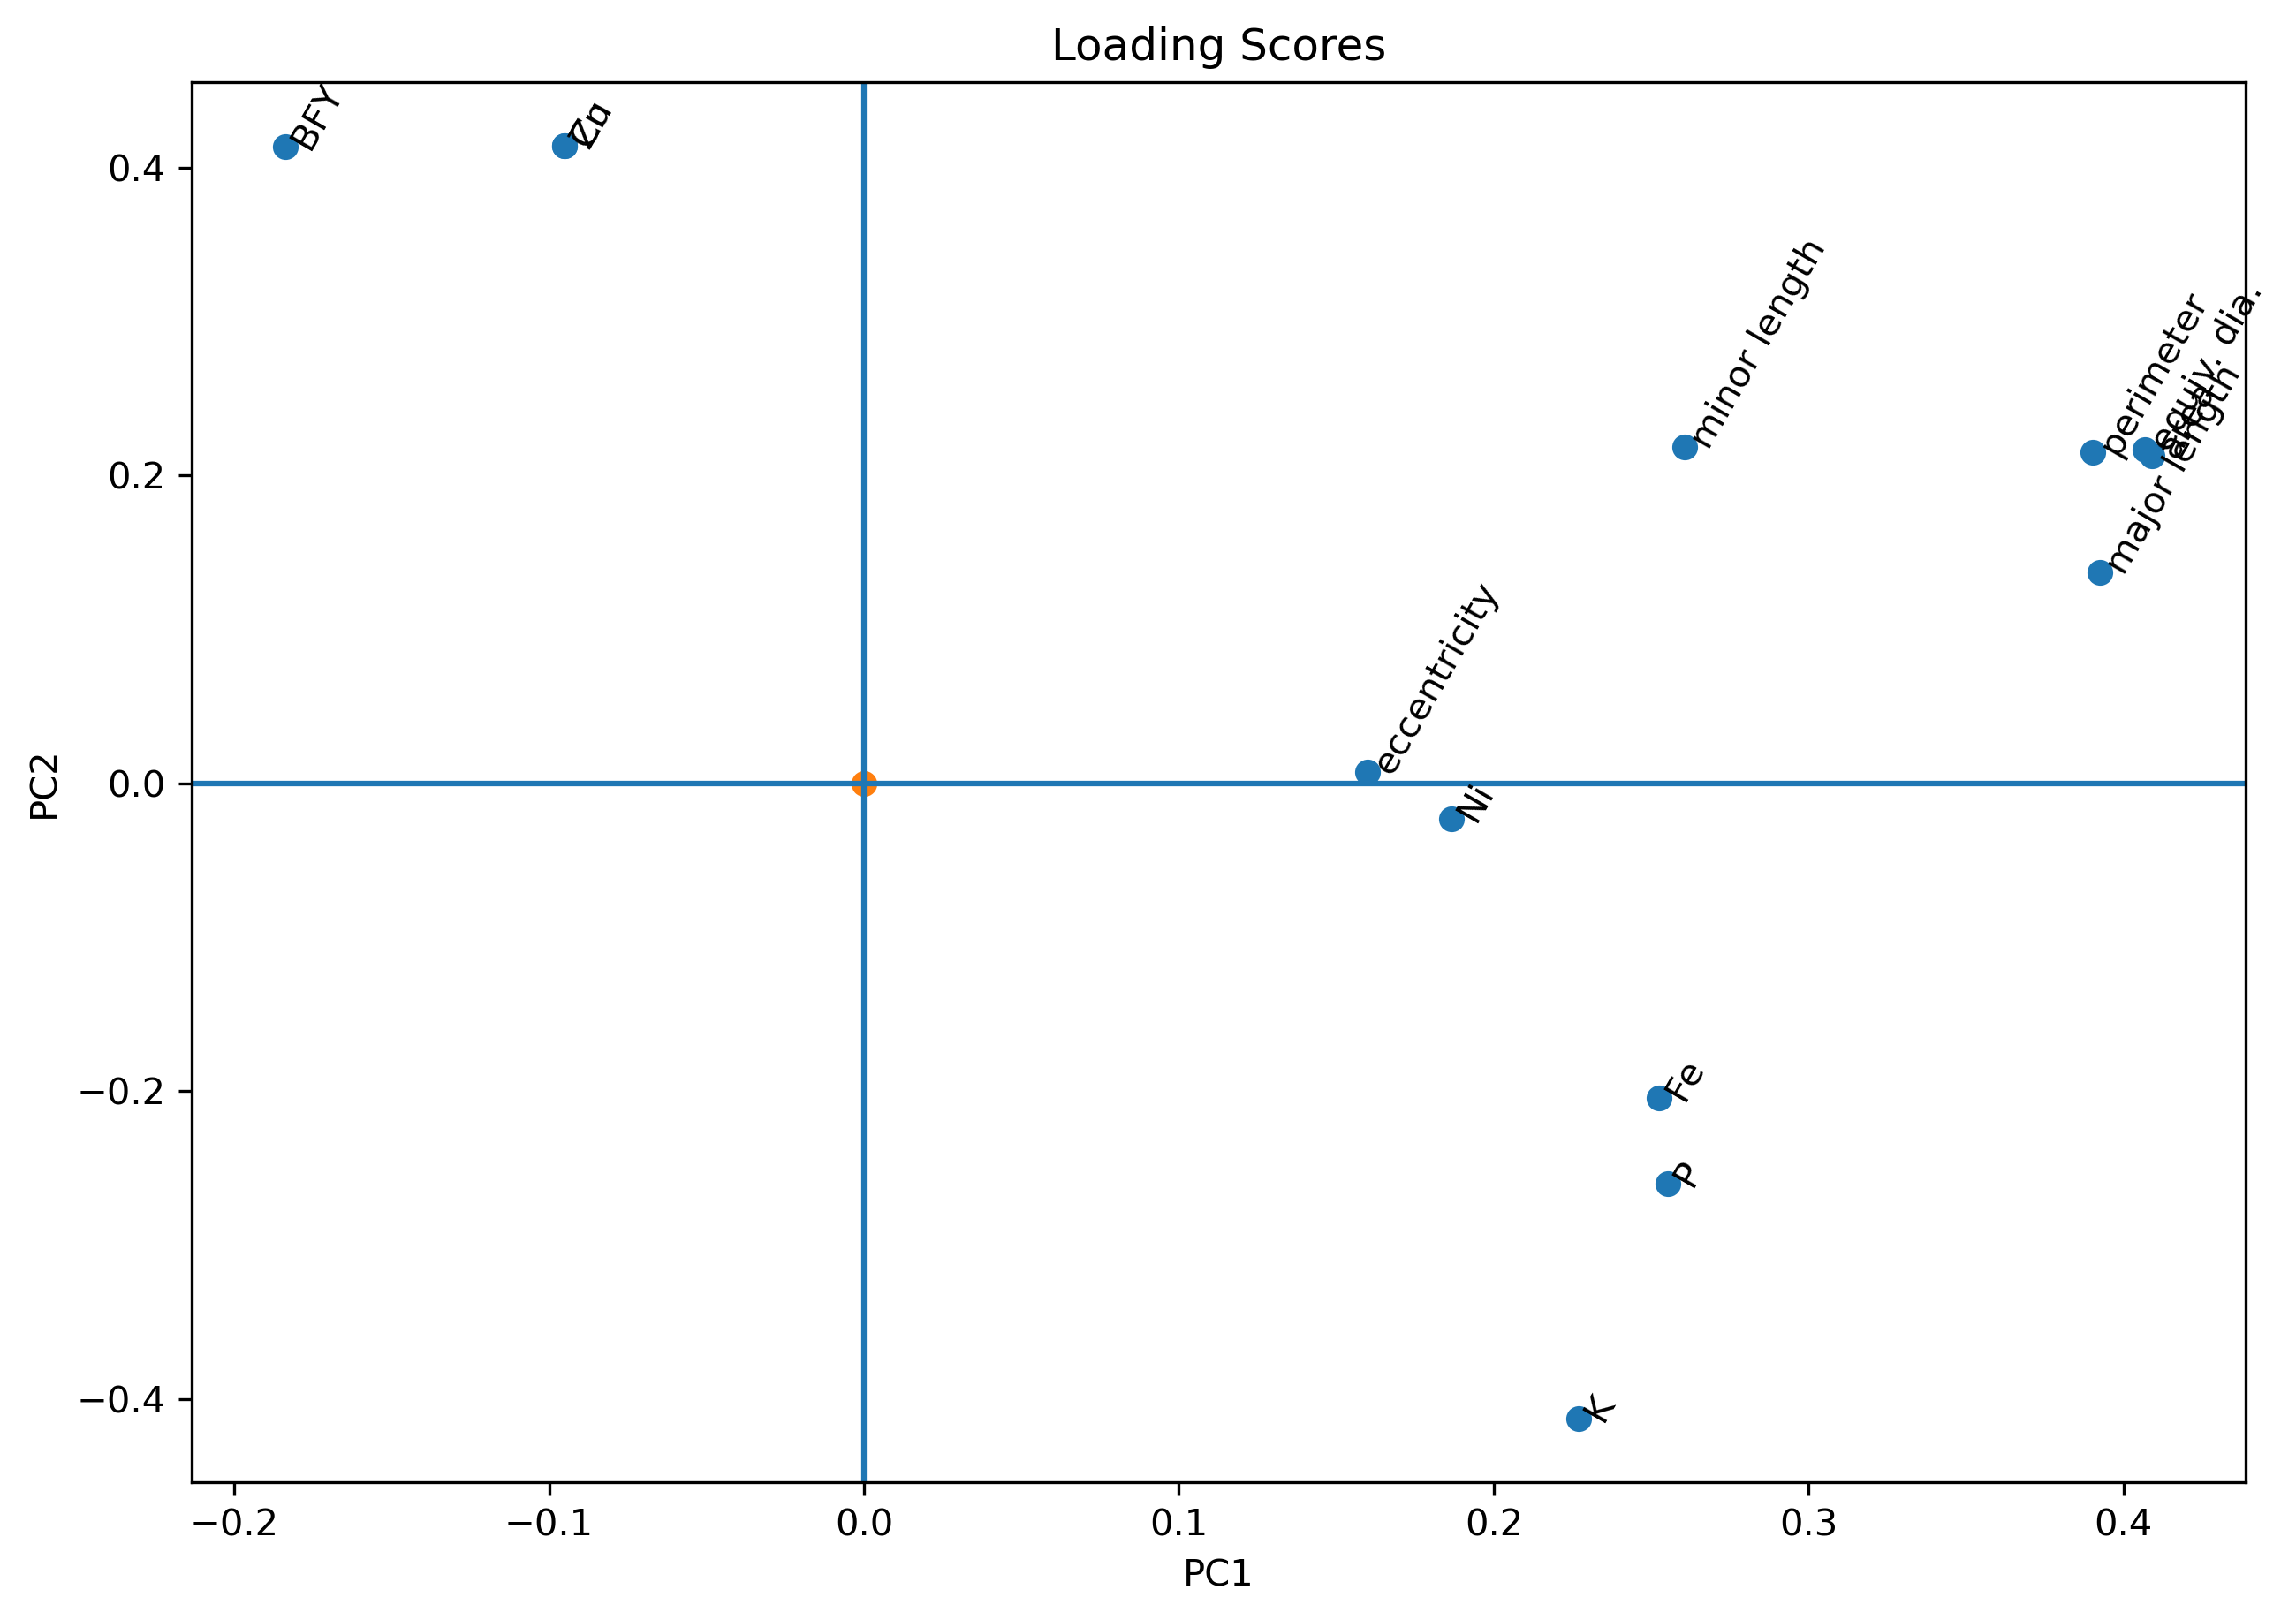

In [85]:
fig = plt.figure(figsize=(10,7),dpi=300);

plt.scatter(pca.components_[0],pca.components_[1]) #, tick_label=PClabels
plt.title('Loading Scores')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.axhline()
plt.axvline()

names = ['area','eccentricity','equiv. dia.','major length','minor length','perimeter',
        'K','P','Ni','Zn',
         'Fe','Cu', 'BFY']

for i, txt in enumerate(names):
    plt.annotate(txt, (pca.components_[0][i], pca.components_[1][i]), rotation=60, size=10)

plt.scatter(0,0)
plt.show()


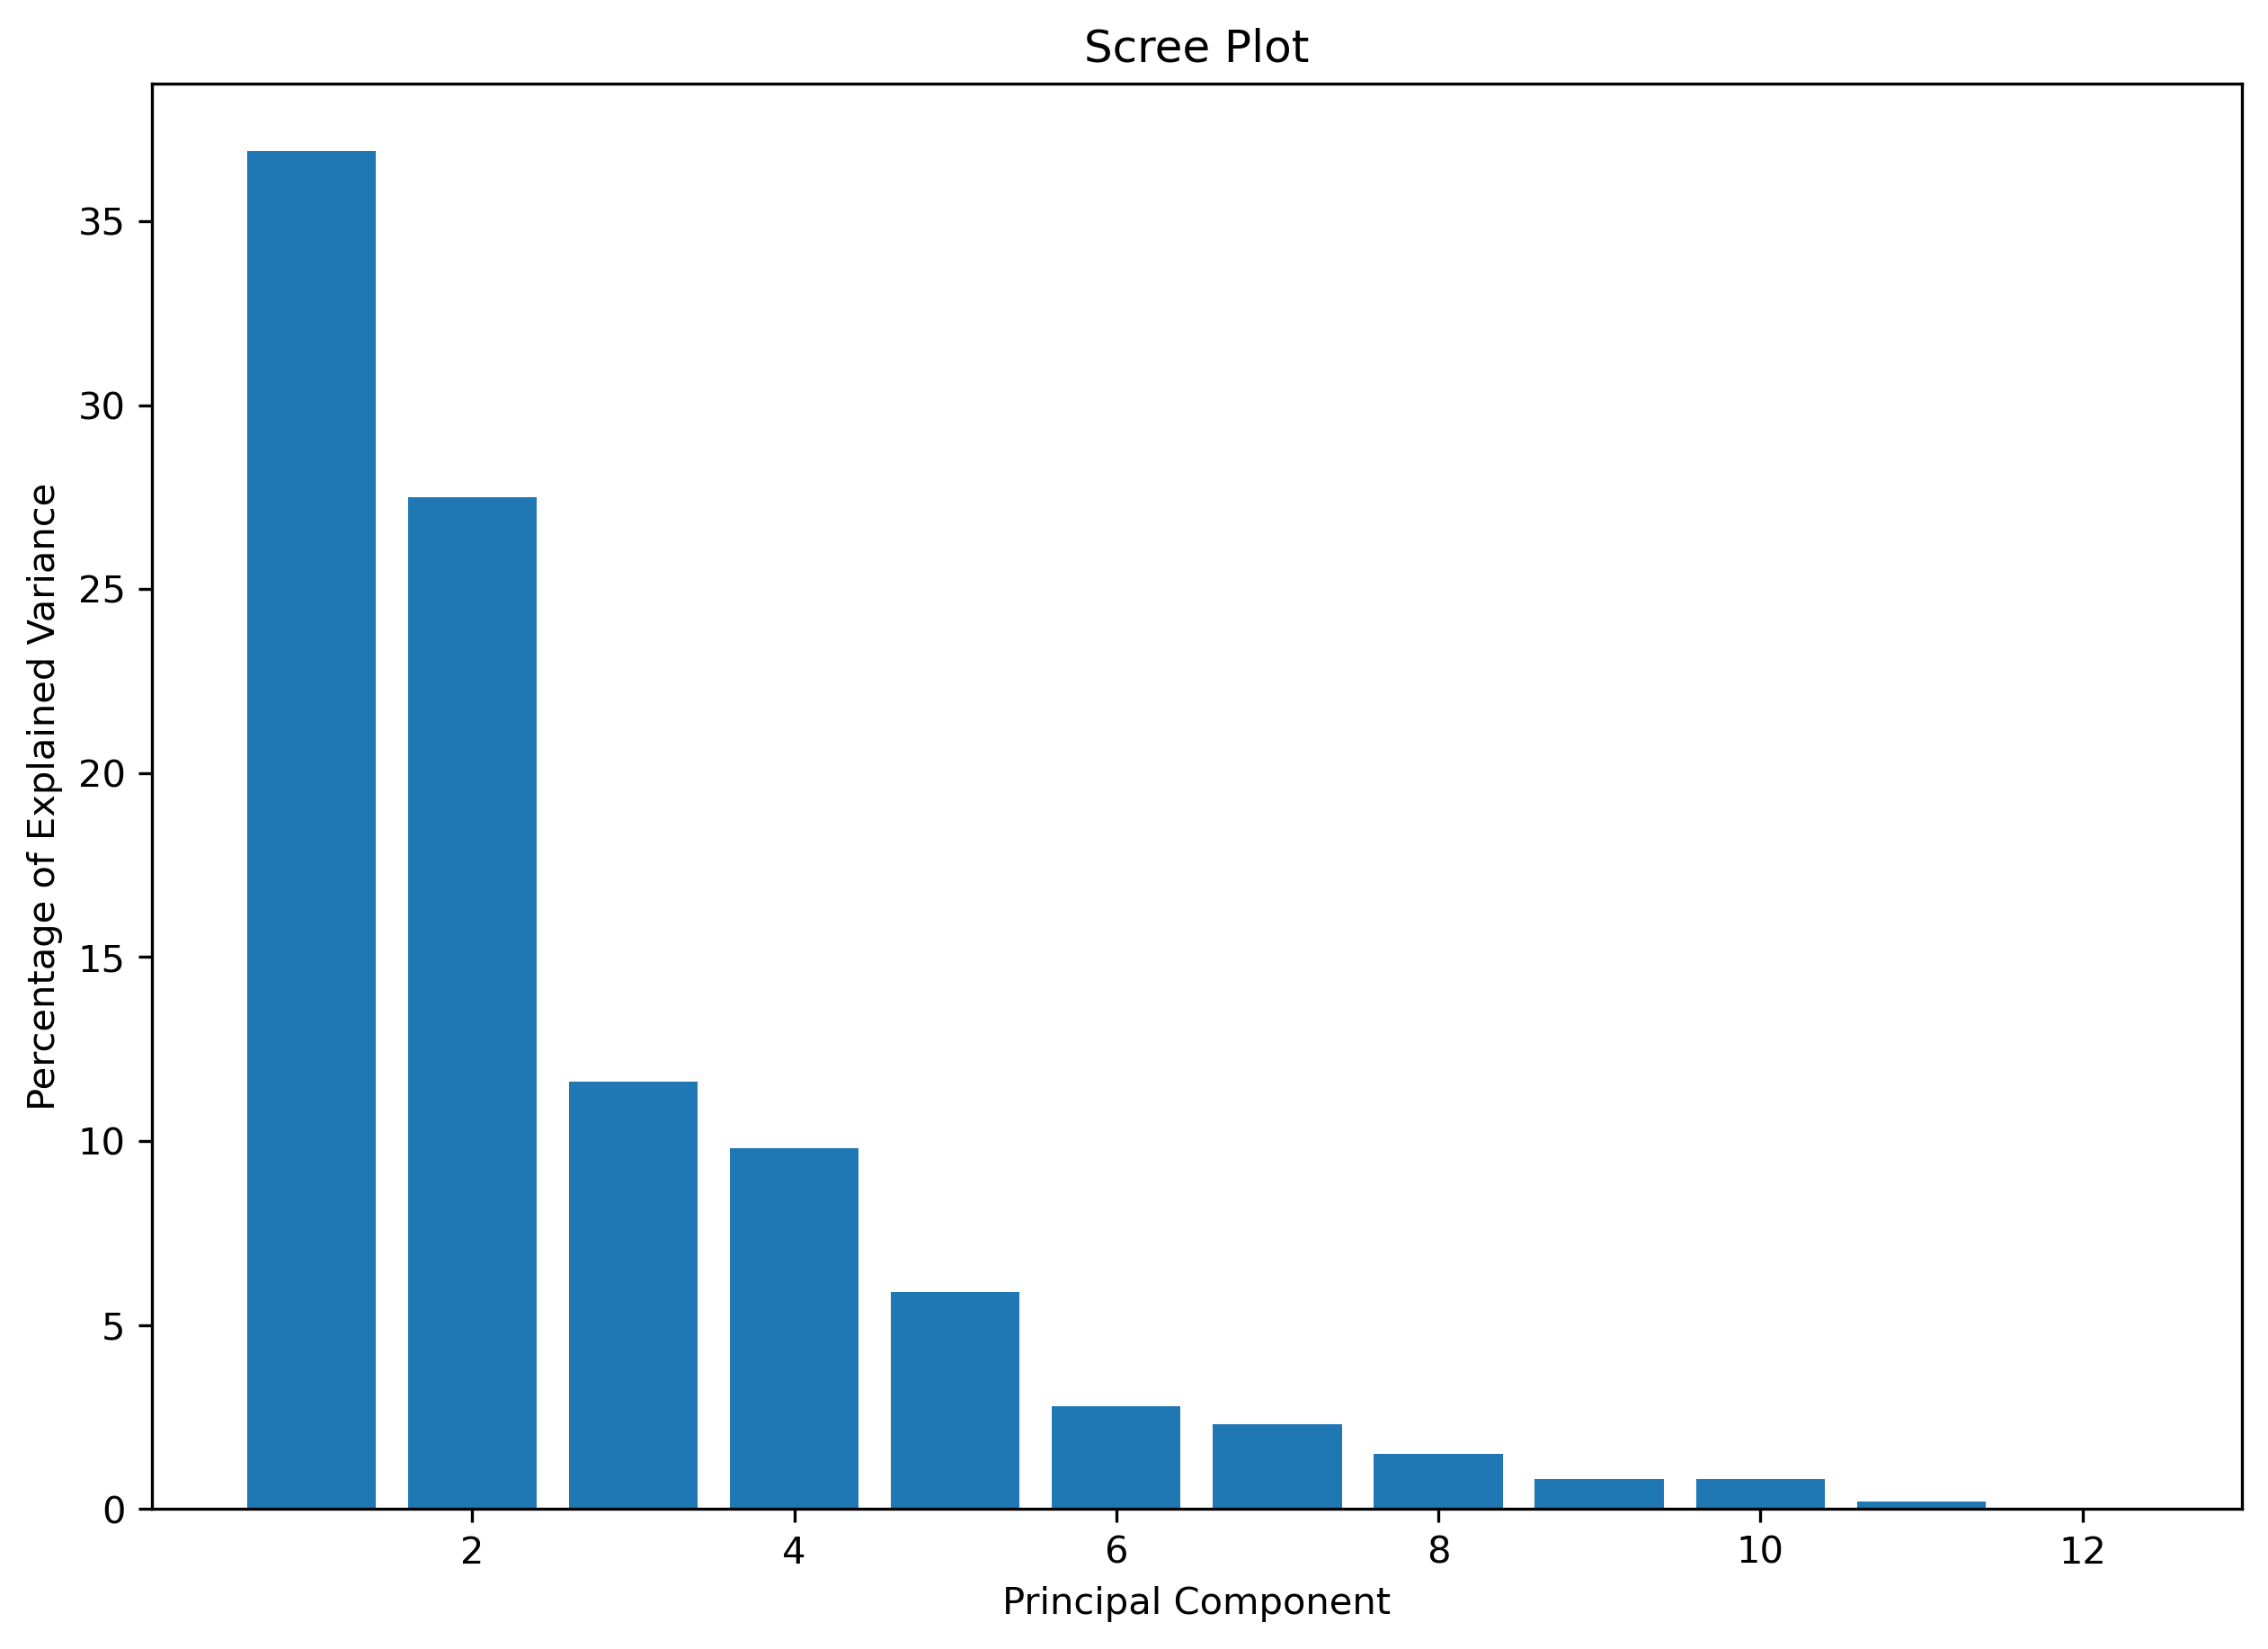

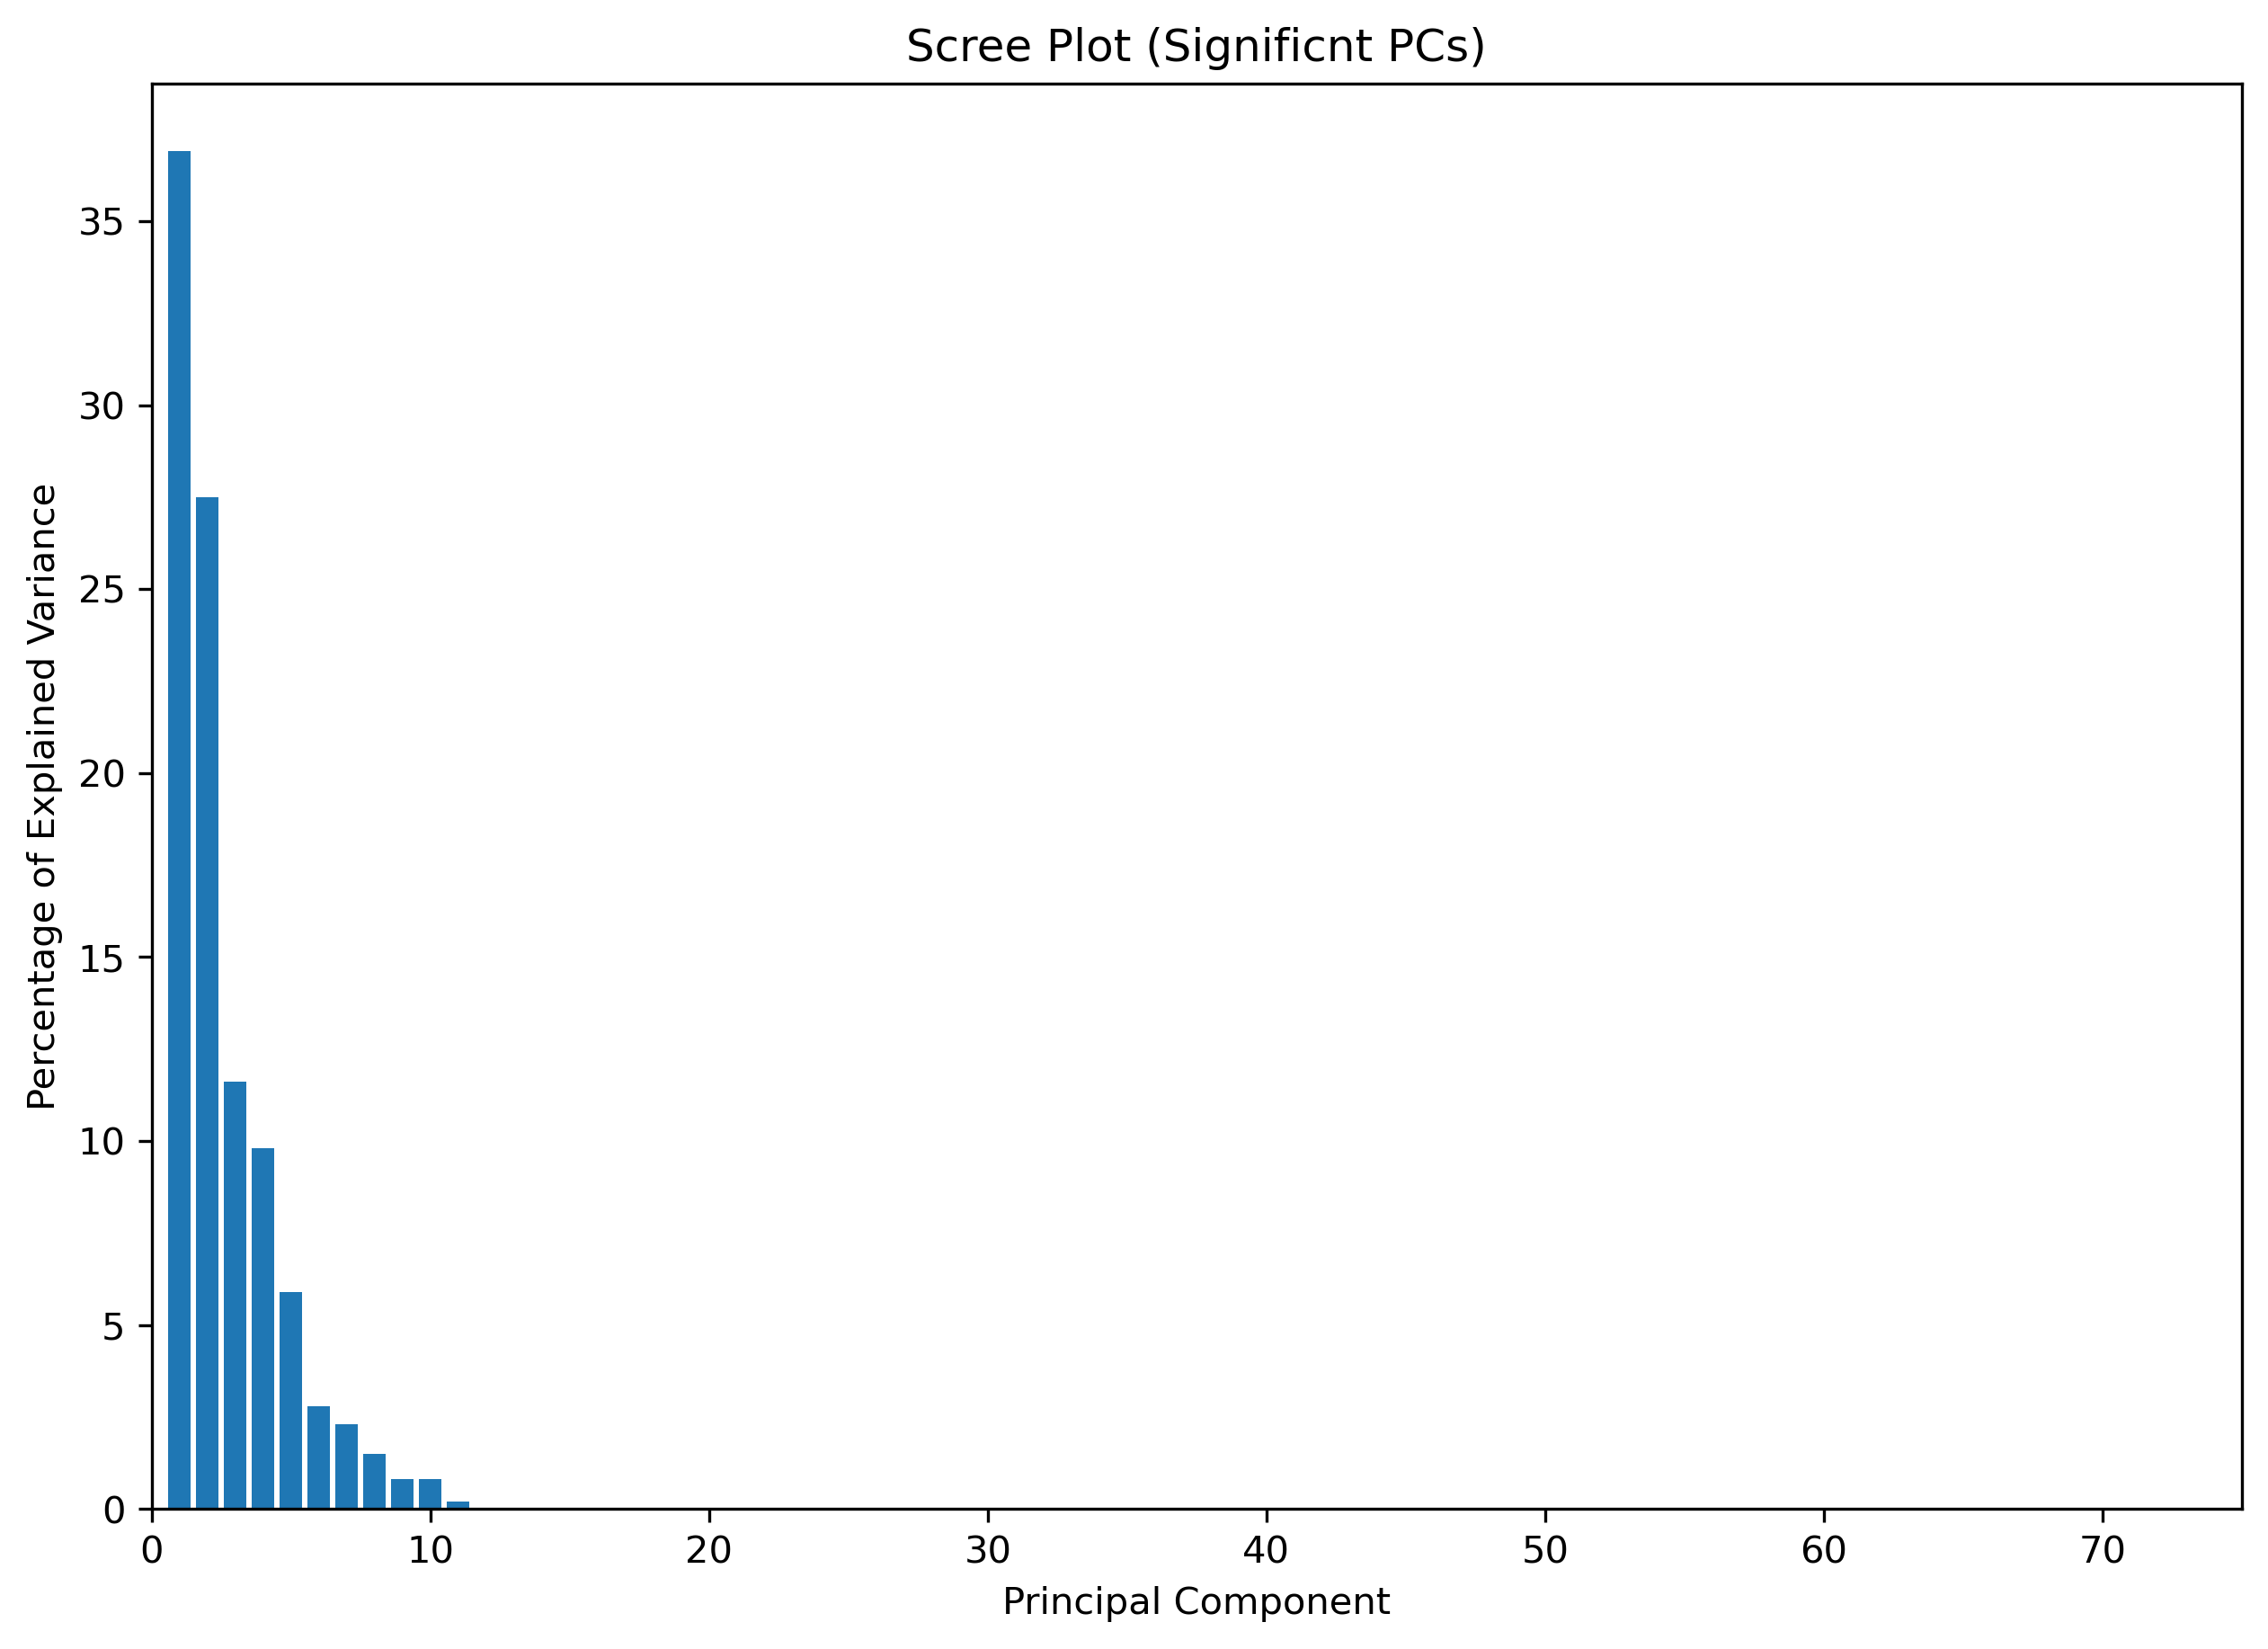

In [86]:
# get scree plot

high_pca = PCA(n_components=12)
high_pca.fit_transform(X_standard)

#calculate percentage of variation in each principal components
per_var=np.round(high_pca.explained_variance_ratio_*100, decimals=1)
PClabels =['PC' + str(x) for x in range(1,len(per_var)+1)]

fig = plt.figure(figsize=(10,7),dpi=300);
plt.bar(x=range(1, len(per_var)+1),height=per_var) #, tick_label=PClabels
plt.title('Scree Plot')
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.show()
#zoom in on the important PCs
fig = plt.figure(figsize=(10,7),dpi=300);
plt.bar(x=range(1, len(per_var)+1),height=per_var) #, tick_label=PClabels
plt.title('Scree Plot (Significnt PCs)')
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.xlim(0,75)
plt.show()

In [77]:
# principalDf['area'] = X[:,0]
# principalDf['eccentricity'] = X[:,1]
# principalDf['equivalent_diameter'] = X[:,2]
# principalDf['major_axis_length'] = X[:,3]
# principalDf['minor_axis_length'] = X[:,4]
# principalDf['perimeter'] = X[:,5]
# principalDf['K'] = X[:,6]
# principalDf['P'] = X[:,7]
# principalDf['Ni'] = X[:,8]
# principalDf['Zn'] = X[:,9]
# principalDf['Fe'] = X[:,10]
# principalDf['Cu'] = X[:,11]
# principalDf['BFY'] = X[:,12]

In [78]:
print(secondaryDf['area'].max())
print(secondaryDf['eccentricity'].max())
print(secondaryDf['equivalent_diameter'].max())
print(secondaryDf['major_axis_length'].max())
print(secondaryDf['minor_axis_length'].max())
print(secondaryDf['perimeter'] .max())
print(secondaryDf['K'].max())
print(secondaryDf['P'].max()) 
print(secondaryDf['Ni'].max()) 
print(secondaryDf['Zn'].max()) 
print(secondaryDf['Fe'].max()) 
print(secondaryDf['Cu'].max()) 
print(secondaryDf['BFY'].max()) 

3.1875
0.9771584640436588
2.014559765517849
4.373612352851659
1.6096129046643122
7.5104076400856545
0.001029257336874656
0.00028565770143713383
0.00013002742780936574
0.010606560774222897
0.0002298700252782765
0.010606560774222897
0.036249565959133895


In [79]:
print(secondaryDf['area'].median())
print(secondaryDf['eccentricity'].median())
print(secondaryDf['equivalent_diameter'].median())
print(secondaryDf['major_axis_length'].median())
print(secondaryDf['minor_axis_length'].median())
print(secondaryDf['perimeter'] .median())
print(secondaryDf['K'].median())
print(secondaryDf['P'].median()) 
print(secondaryDf['Ni'].median()) 
print(secondaryDf['Zn'].median()) 
print(secondaryDf['Fe'].median()) 
print(secondaryDf['Cu'].median()) 
print(secondaryDf['BFY'].median()) 

0.875
0.8299250027587322
1.055502061411188
1.4142135623730951
0.7788798979701944
2.914213562373095
5.605425389496696e-05
6.106840210714945e-05
5.182665716190569e-05
0.001213091050156113
7.881729319680044e-05
0.001213091050156113
0.020938889050117357


In [80]:
secondaryDf['original index'] = secondaryDf.index.to_numpy()

In [81]:
secondaryDf.reset_index(drop=True, inplace=True)

In [82]:
secondaryDf

,Pixel_count,area,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,perimeter,K,P,Ni,Zn,Fe,Cu,BFY,PC1,PC2,original index
0,12,0.7500,0.881527,0.977205,1.497683,0.707107,2.621320,0.000048,0.000036,0.000080,0.001324,0.000088,0.001324,0.021890,-0.989849,0.580283,0
1,20,1.2500,0.869033,1.261566,1.790358,0.885787,3.828427,0.000052,0.000086,0.000066,0.001899,0.000064,0.001899,0.025441,1.447044,1.652713,3
2,17,1.0625,0.945978,1.163107,2.102629,0.681738,2.267767,0.000052,0.000050,0.000068,0.001087,0.000094,0.001087,0.022809,0.190804,0.380654,4
3,25,1.5625,0.712771,1.410474,1.729752,1.213243,4.328427,0.000042,0.000056,0.000044,0.001829,0.000106,0.001829,0.022554,2.758063,1.779468,5
4,14,0.8750,0.829925,1.055502,1.414214,0.788954,2.974874,0.000053,0.000081,0.000071,0.001615,0.000084,0.001615,0.021853,-0.388515,0.714367,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318,17,1.0625,0.919900,1.163107,1.868381,0.732690,3.474874,0.000454,0.000168,0.000039,0.000096,0.000134,0.000096,0.006650,1.128845,-3.459733,550
319,30,1.8750,0.930202,1.545097,2.607961,0.957245,5.389087,0.000627,0.000147,0.000069,0.000081,0.000129,0.000081,0.007319,5.363885,-3.042151,552
320,11,0.6875,0.912871,0.935603,1.477098,0.603023,1.414214,0.000710,0.000164,0.000037,0.000117,0.000084,0.000117,0.007726,-1.716832,-3.896015,553
321,28,1.7500,0.928385,1.492705,2.930370,1.088985,4.630204,0.000504,0.000169,0.000081,0.000120,0.000143,0.000120,0.006953,5.469790,-3.074006,554


<AxesSubplot:xlabel='Pixel_count', ylabel='Count'>

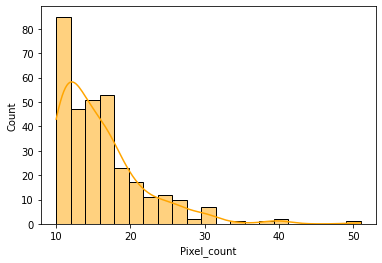

In [83]:
sns.histplot(data=secondaryDf, x="Pixel_count", kde=True,color='orange')



<AxesSubplot:xlabel='eccentricity', ylabel='Count'>

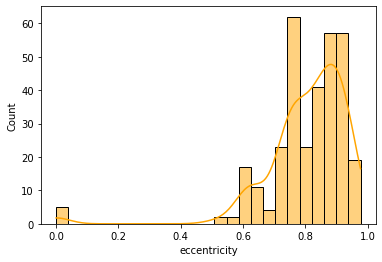

In [84]:
sns.histplot(data=secondaryDf, x="eccentricity", kde=True,color='orange')



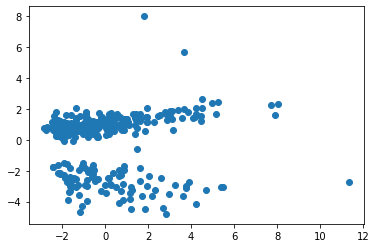

In [85]:
plt.scatter(secondaryDf['PC1'],secondaryDf['PC2'])

In [86]:
# Custom condition to view cells
True_list = secondaryDf.loc[
    (secondaryDf['eccentricity'] > 0) &
    (secondaryDf['eccentricity'] <= 0.7)
    
   ].index.tolist()
print( len(True_list) )

36


In [87]:
True_list

[5,
 8,
 9,
 10,
 27,
 49,
 51,
 53,
 67,
 69,
 70,
 81,
 86,
 92,
 93,
 95,
 96,
 102,
 105,
 107,
 141,
 149,
 151,
 164,
 168,
 175,
 189,
 223,
 241,
 249,
 256,
 259,
 267,
 269,
 273,
 283]

In [88]:
(secondaryDf['K']/secondaryDf['P']).median()

1.1391682716515799

In [89]:

# now create mult label data frame with strict conditions

labels = [0] * mod_X.shape[0]


secondaryDf['text_labels'] = labels


# (live)
K_threshold=4.2e-05 #default is median
KbyP_threshold=1 #default is median

True_list = secondaryDf.loc[
    (secondaryDf['major_axis_length']>=1) & 
    (secondaryDf['major_axis_length']<= 3) &
    (secondaryDf['minor_axis_length']>=0.5) & 
    (secondaryDf['minor_axis_length']<= 1.5) &
    (secondaryDf['K']>=secondaryDf['K'].median()) &
    (secondaryDf['K']/secondaryDf['P']>=(secondaryDf['K']/secondaryDf['P']).median())
   ].index.tolist()

print( len(True_list) )

for idx in True_list:
    labels[idx]=1
    
# (Dead)
Ni_threshold=2.04e-05 #default is half of median
NibyP_threshold=0.48 #default is half of median

NibyZn_threshold=0.021 #default is half of median
NibyFe_threshold=0.32 #default is half of median
NibyK_threshold=0.485 #default is half of median
CubyK_threshold=13 #default is half of median

True_list = secondaryDf.loc[
    (secondaryDf['major_axis_length']>=1) & 
    (secondaryDf['major_axis_length']<= 3) &
    (secondaryDf['minor_axis_length']>=0.5) & 
    (secondaryDf['minor_axis_length']<= 1.5) &
    (secondaryDf['Ni']>=0.25*secondaryDf['Ni'].median()) &
    (secondaryDf['Ni']/secondaryDf['P']>= 0.25*(secondaryDf['Ni']/secondaryDf['P']).median()) &
    (secondaryDf['Ni']/secondaryDf['Zn']>= 0.25*(secondaryDf['Ni']/secondaryDf['Zn']).median()) &
    (secondaryDf['Ni']/secondaryDf['Fe']>= 0.25*(secondaryDf['Ni']/secondaryDf['Fe']).median()) &
    (secondaryDf['Ni']/secondaryDf['K']>= 0.25*(secondaryDf['Ni']/secondaryDf['K']).median()) &
    (secondaryDf['Cu']/secondaryDf['K']>= 0.25*(secondaryDf['Cu']/secondaryDf['K']).median())
   ].index.tolist()    
    
print( len(True_list) )

for idx in True_list:
    labels[idx]=2 
    
y=labels
    
for idx in range(len(labels)):
    if labels[idx] ==0:
        labels[idx] = 'unassigned'
    if labels[idx] ==1:
        labels[idx] = 'live cells'
    if labels[idx] ==2:
        labels[idx] = 'dead cells'


        
        
secondaryDf['text_labels'] = labels


122
219


dict_keys(['dead cells', 'unassigned', 'live cells'])


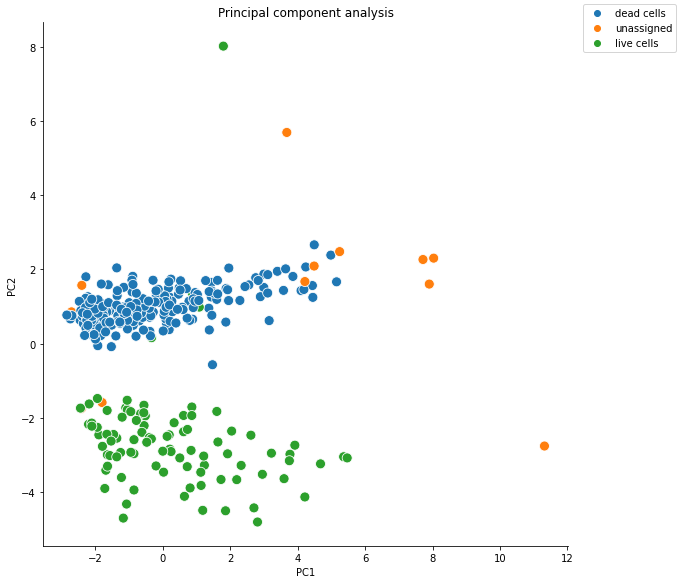

In [90]:
pp = sns.pairplot(data=secondaryDf,
                  y_vars=['PC2'],
                  x_vars=['PC1'],
                  kind = 'scatter', 
                 diag_kind='hist', corner = 'True', hue='text_labels',  height=8,plot_kws={"s": 100}
                 )
leg_handles = pp._legend_data.values()
leg_labels = pp._legend_data.keys()

pp.fig.legend(handles=leg_handles, labels=leg_labels, loc='upper right', ncol=1)
pp._legend.remove() # remove existing legend
print(leg_labels)

pp.set(xlabel='PC1',
       ylabel='PC2',
       title='Principal component analysis')



KeyError: 'KO_label'

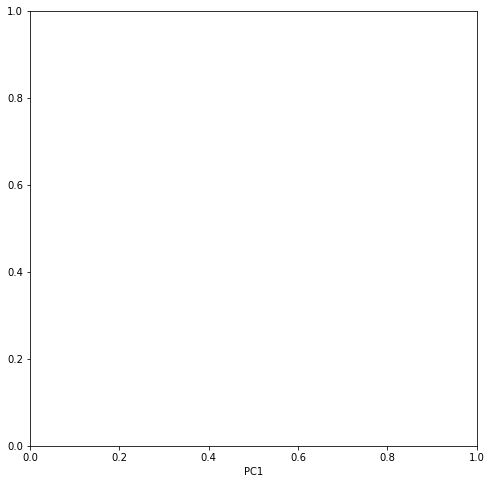

In [91]:
pp = sns.pairplot(data=secondaryDf,
                  y_vars=['PC2'],
                  x_vars=['PC1'],
                  kind = 'scatter', 
                 diag_kind='hist', corner = 'True', hue='KO_label',  height=8,plot_kws={"s": 100}
                 )
leg_handles = pp._legend_data.values()
leg_labels = pp._legend_data.keys()

pp.fig.legend(handles=leg_handles, labels=leg_labels, loc='upper right', ncol=1)
pp._legend.remove() # remove existing legend
print(leg_labels)

pp.set(xlabel='PC1',
       ylabel='PC2',
       title='Principal component analysis (annotations)')



In [92]:
np.unique(secondaryDf.K_obs_labels.to_numpy(), return_counts=True)

AttributeError: 'DataFrame' object has no attribute 'K_obs_labels'

KeyError: 'K_obs_labels'

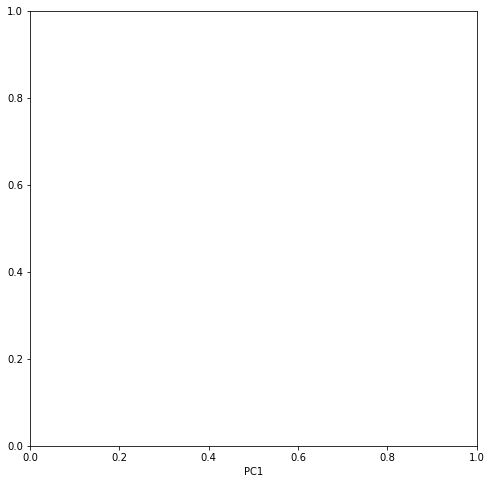

In [93]:
# observations about Potassium from Kiwon
pp = sns.pairplot(data=secondaryDf,
                  y_vars=['PC2'],
                  x_vars=['PC1'],
                  kind = 'scatter', 
                 diag_kind='hist', corner = 'True', hue='K_obs_labels',  height=8,plot_kws={"s": 100}
                 )
leg_handles = pp._legend_data.values()
leg_labels = pp._legend_data.keys()

pp.fig.legend(handles=leg_handles, labels=leg_labels, loc='upper right', ncol=1)
pp._legend.remove() # remove existing legend
print(leg_labels)

pp.set(xlabel='PC1',
       ylabel='PC2',
       title='Principal component analysis (tags on K content)')



KeyError: 'Ni_obs_labels'

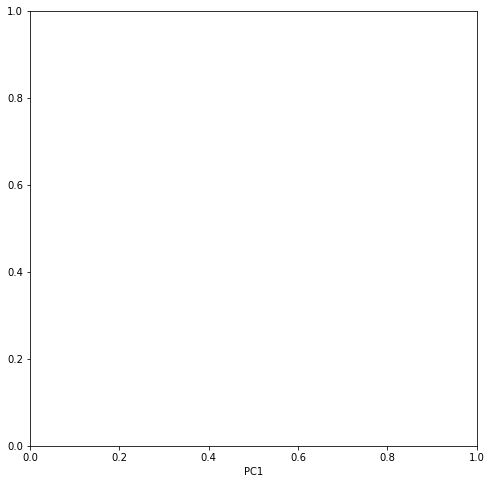

In [94]:
# observations about Ni from Kiwon
pp = sns.pairplot(data=secondaryDf,
                  y_vars=['PC2'],
                  x_vars=['PC1'],
                  kind = 'scatter', 
                 diag_kind='hist', corner = 'True', hue='Ni_obs_labels',  height=8,plot_kws={"s": 100}
                 )
leg_handles = pp._legend_data.values()
leg_labels = pp._legend_data.keys()

pp.fig.legend(handles=leg_handles, labels=leg_labels, loc='upper right', ncol=1)
pp._legend.remove() # remove existing legend
print(leg_labels)

pp.set(xlabel='PC1',
       ylabel='PC2',
       title='Principal component analysis (tags on Ni content)')



KeyError: 'Fe_obs_labels'

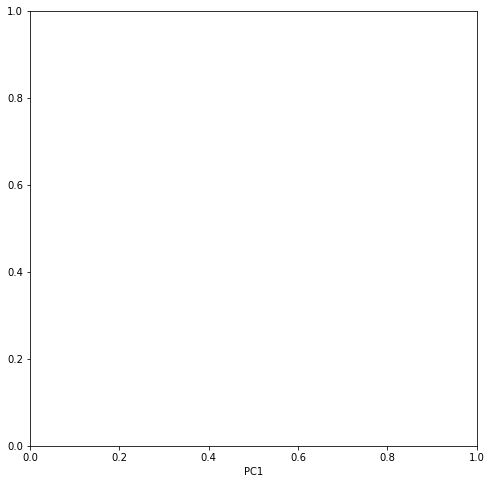

In [95]:
# observations about Fe from Kiwon
pp = sns.pairplot(data=secondaryDf,
                  y_vars=['PC2'],
                  x_vars=['PC1'],
                  kind = 'scatter', 
                 diag_kind='hist', corner = 'True', hue='Fe_obs_labels',  height=8,plot_kws={"s": 100}
                 )
leg_handles = pp._legend_data.values()
leg_labels = pp._legend_data.keys()

pp.fig.legend(handles=leg_handles, labels=leg_labels, loc='upper right', ncol=1)
pp._legend.remove() # remove existing legend
print(leg_labels)

pp.set(xlabel='PC1',
       ylabel='PC2',
       title='Principal component analysis (tags on Fe content)')



KeyError: 'Cu_obs_labels'

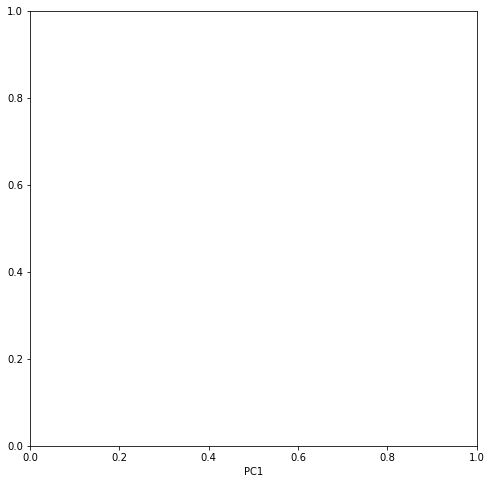

In [96]:
# observations about Cu from Kiwon
pp = sns.pairplot(data=secondaryDf,
                  y_vars=['PC2'],
                  x_vars=['PC1'],
                  kind = 'scatter', 
                 diag_kind='hist', corner = 'True', hue='Cu_obs_labels',  height=8,plot_kws={"s": 100}
                 )
leg_handles = pp._legend_data.values()
leg_labels = pp._legend_data.keys()

pp.fig.legend(handles=leg_handles, labels=leg_labels, loc='upper right', ncol=1)
pp._legend.remove() # remove existing legend
print(leg_labels)

pp.set(xlabel='PC1',
       ylabel='PC2',
       title='Principal component analysis (tags on Cu content)')



KeyError: 'Ca_obs_labels'

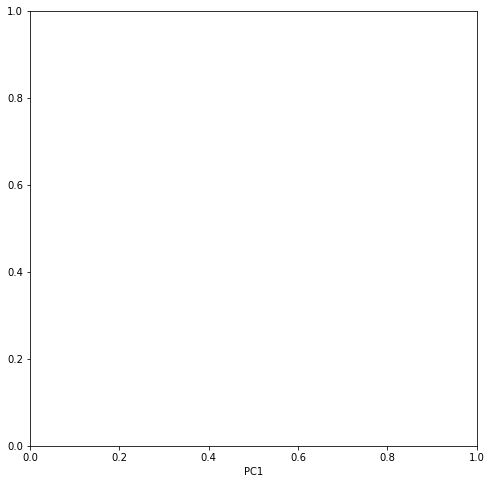

In [97]:
# observations about Ca from Kiwon
pp = sns.pairplot(data=secondaryDf,
                  y_vars=['PC2'],
                  x_vars=['PC1'],
                  kind = 'scatter', 
                 diag_kind='hist', corner = 'True', hue='Ca_obs_labels',  height=8,plot_kws={"s": 100}
                 )
leg_handles = pp._legend_data.values()
leg_labels = pp._legend_data.keys()

pp.fig.legend(handles=leg_handles, labels=leg_labels, loc='upper right', ncol=1)
pp._legend.remove() # remove existing legend
print(leg_labels)

pp.set(xlabel='PC1',
       ylabel='PC2',
       title='Principal component analysis (tags on Ca content)')



KeyError: 'Zn_obs_labels'

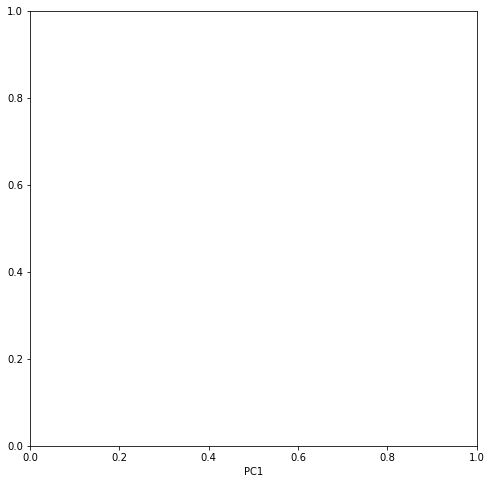

In [98]:
# observations about Zn from Kiwon
pp = sns.pairplot(data=secondaryDf,
                  y_vars=['PC2'],
                  x_vars=['PC1'],
                  kind = 'scatter', 
                 diag_kind='hist', corner = 'True', hue='Zn_obs_labels',  height=8,plot_kws={"s": 100}
                 )
leg_handles = pp._legend_data.values()
leg_labels = pp._legend_data.keys()

pp.fig.legend(handles=leg_handles, labels=leg_labels, loc='upper right', ncol=1)
pp._legend.remove() # remove existing legend
print(leg_labels)

pp.set(xlabel='PC1',
       ylabel='PC2',
       title='Principal component analysis (tags on Zn content)')



In [99]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(secondaryDf)

,Pixel_count,area,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,perimeter,K,P,Ni,Zn,Fe,Cu,BFY,PC1,PC2,original index,text_labels
0,12,0.7500,0.881527,0.977205,1.497683,0.707107,2.621320,0.000048,0.000036,0.000080,0.001324,0.000088,0.001324,0.021890,-0.989849,0.580283,0,dead cells
1,20,1.2500,0.869033,1.261566,1.790358,0.885787,3.828427,0.000052,0.000086,0.000066,0.001899,0.000064,0.001899,0.025441,1.447044,1.652713,3,dead cells
2,17,1.0625,0.945978,1.163107,2.102629,0.681738,2.267767,0.000052,0.000050,0.000068,0.001087,0.000094,0.001087,0.022809,0.190804,0.380654,4,dead cells
3,25,1.5625,0.712771,1.410474,1.729752,1.213243,4.328427,0.000042,0.000056,0.000044,0.001829,0.000106,0.001829,0.022554,2.758063,1.779468,5,dead cells
4,14,0.8750,0.829925,1.055502,1.414214,0.788954,2.974874,0.000053,0.000081,0.000071,0.001615,0.000084,0.001615,0.021853,-0.388515,0.714367,8,dead cells
5,22,1.3750,0.665548,1.323142,1.616812,1.206717,4.181981,0.000043,0.000048,0.000098,0.001799,0.000108,0.001799,0.022674,2.553481,1.585338,10,dead cells
6,10,0.6250,0.870388,0.892062,1.284523,0.632456,2.517767,0.000072,0.000064,0.000036,0.001682,0.000068,0.001682,0.022783,-2.149204,0.855306,12,dead cells
7,40,2.5000,0.801105,1.784124,2.508883,1.501627,6.328427,0.000065,0.000084,0.000092,0.001670,0.000107,0.001670,0.026741,7.716956,2.268945,13,unassigned
8,10,0.6250,0.616441,0.892062,1.000000,0.787401,2.267767,0.000041,0.000056,0.000049,0.001416,0.000074,0.001416,0.019791,-2.451722,0.640101,14,dead cells
9,10,0.6250,0.616441,0.892062,1.000000,0.787401,2.267767,0.000052,0.000086,0.000055,0.001339,0.000087,0.001339,0.024286,-2.238507,0.518733,16,dead cells


In [100]:
secondaryDf[secondaryDf['PC2'] >= 8]

,Pixel_count,area,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,perimeter,K,P,Ni,Zn,Fe,Cu,BFY,PC1,PC2,original index,text_labels
270,20,1.25,0.733632,1.261566,1.531812,1.040939,3.62132,0.000059,0.000034,0.000055,0.009517,0.000092,0.009517,0.022643,1.798037,8.014905,465,live cells


In [101]:
secondaryDf[secondaryDf['text_labels'] == 'unassigned']

,Pixel_count,area,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,perimeter,K,P,Ni,Zn,Fe,Cu,BFY,PC1,PC2,original index,text_labels
7,40,2.5000,0.801105,1.784124,2.508883,1.501627,6.328427,0.000065,0.000084,0.000092,0.001670,0.000107,0.001670,0.026741,7.716956,2.268945,13,unassigned
23,12,0.7500,0.000000,0.977205,0.957427,0.957427,2.414214,0.000057,0.000227,0.000040,0.003066,0.000100,0.003066,0.020419,-1.764700,0.938683,42,unassigned
80,12,0.7500,0.000000,0.977205,0.957427,0.957427,2.414214,0.000335,0.000090,0.000112,0.000136,0.000075,0.000136,0.013155,-1.797626,-1.582424,144,unassigned
82,12,0.7500,0.000000,0.977205,0.957427,0.957427,2.414214,0.000383,0.000095,0.000037,0.000082,0.000084,0.000082,0.012113,-2.409824,-1.743057,148,unassigned
124,29,1.8125,0.969379,1.519127,3.100472,0.761382,5.785534,0.000047,0.000060,0.000052,0.001899,0.000054,0.001899,0.023655,4.489796,2.092939,220,unassigned
131,12,0.7500,0.000000,0.977205,0.957427,0.957427,2.414214,0.000041,0.000064,0.000039,0.001176,0.000060,0.001176,0.019094,-2.704161,0.858969,229,unassigned
162,18,1.1250,0.915370,1.196827,1.946103,0.783529,3.871320,0.000111,0.000235,0.000100,0.010607,0.000230,0.010607,0.022465,3.679533,5.690237,288,unassigned
169,40,2.5000,0.950251,1.784124,3.507590,1.092561,7.181981,0.000053,0.000056,0.000075,0.001821,0.000085,0.001821,0.023117,8.033447,2.305322,301,unassigned
178,39,2.4375,0.977158,1.761681,3.913912,0.831753,7.510408,0.000066,0.000116,0.000053,0.001831,0.000078,0.001831,0.020964,7.903476,1.607235,319,unassigned
215,30,1.8750,0.963336,1.545097,3.100404,0.831828,4.931981,0.000049,0.000044,0.000049,0.001261,0.000054,0.001261,0.023399,4.215472,1.675619,381,unassigned


In [102]:
interactive_plot = interactive(viewer, idx=(0, len(X_bin)-1))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=279, description='idx', max=558), Output()), _dom_classes=('widget-inter…

In [103]:


with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(secondaryDf)

,Pixel_count,area,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,perimeter,K,P,Ni,Zn,Fe,Cu,BFY,PC1,PC2,original index,text_labels
0,12,0.7500,0.881527,0.977205,1.497683,0.707107,2.621320,0.000048,0.000036,0.000080,0.001324,0.000088,0.001324,0.021890,-0.989849,0.580283,0,dead cells
1,20,1.2500,0.869033,1.261566,1.790358,0.885787,3.828427,0.000052,0.000086,0.000066,0.001899,0.000064,0.001899,0.025441,1.447044,1.652713,3,dead cells
2,17,1.0625,0.945978,1.163107,2.102629,0.681738,2.267767,0.000052,0.000050,0.000068,0.001087,0.000094,0.001087,0.022809,0.190804,0.380654,4,dead cells
3,25,1.5625,0.712771,1.410474,1.729752,1.213243,4.328427,0.000042,0.000056,0.000044,0.001829,0.000106,0.001829,0.022554,2.758063,1.779468,5,dead cells
4,14,0.8750,0.829925,1.055502,1.414214,0.788954,2.974874,0.000053,0.000081,0.000071,0.001615,0.000084,0.001615,0.021853,-0.388515,0.714367,8,dead cells
5,22,1.3750,0.665548,1.323142,1.616812,1.206717,4.181981,0.000043,0.000048,0.000098,0.001799,0.000108,0.001799,0.022674,2.553481,1.585338,10,dead cells
6,10,0.6250,0.870388,0.892062,1.284523,0.632456,2.517767,0.000072,0.000064,0.000036,0.001682,0.000068,0.001682,0.022783,-2.149204,0.855306,12,dead cells
7,40,2.5000,0.801105,1.784124,2.508883,1.501627,6.328427,0.000065,0.000084,0.000092,0.001670,0.000107,0.001670,0.026741,7.716956,2.268945,13,unassigned
8,10,0.6250,0.616441,0.892062,1.000000,0.787401,2.267767,0.000041,0.000056,0.000049,0.001416,0.000074,0.001416,0.019791,-2.451722,0.640101,14,dead cells
9,10,0.6250,0.616441,0.892062,1.000000,0.787401,2.267767,0.000052,0.000086,0.000055,0.001339,0.000087,0.001339,0.024286,-2.238507,0.518733,16,dead cells


In [104]:
# calculate kmeans cluster centers
def _format_soft_km_axes(ax, **kwargs):
    
    """ 
    input: axes and key word arguments
    param: ax - axes to be formatted
    param: border - boolean, True = grey border, False = None. Default True
    """
    
    rc('font', family = 'serif')
    
    # Set border
    border = True
    if 'border' in kwargs:
        border = kwargs['border']
        
    if border:
        ax.spines['top'].set_color('grey')
        ax.spines['right'].set_color('grey')
        ax.spines['bottom'].set_color('grey')
        ax.spines['left'].set_color('grey')
    else:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        
    # Format label and tick fonts
    tickwidth = 1
    if border == False:
        tickwidth = 2
    
    ax.xaxis.label.set_size(16)
    ax.xaxis.label.set_color('grey')
    ax.yaxis.label.set_size(16)
    ax.yaxis.label.set_color('grey')
    ax.title.set_color('grey')
    ax.tick_params(axis='both', which='major', labelsize=16, labelcolor = 'grey')
    
    return ax

def soft_clustering_weights(data, cluster_centres, **kwargs):
    
    """
    Function to calculate the weights from soft k-means
    data: array,. Features arranged across the columns with each row being a different data point
    cluster_centres: array of cluster centres. Input kmeans.cluster_centres_ directly.
    param: m - keyword argument, fuzziness of the clustering. Default 2
    """
    
    # Fuzziness parameter m>=1. Where m=1 => hard segmentation
    m = 2
    if 'm' in kwargs:
        m = kwargs['m']
    
    Nclusters = cluster_centres.shape[0]
    Ndp = data.shape[0]
    Nfeatures = data.shape[1]

    # Get distances from the cluster centres for each data point and each cluster
    EuclidDist = np.zeros((Ndp, Nclusters))
    for i in range(Nclusters):
        EuclidDist[:,i] = np.sum((data-np.matlib.repmat(cluster_centres[i], Ndp, 1))**2,axis=1)
    

    
    # Denominator of the weight from wikipedia:
    invWeight = EuclidDist**(2/(m-1))*np.matlib.repmat(np.sum((1./EuclidDist)**(2/(m-1)),axis=1).reshape(-1,1),1,Nclusters)
    Weight = 1./invWeight
    
    return Weight



In [105]:
#end

In [112]:
#perform regular sklearn kmeans and plot the cluster centeres

import pandas as pd
import numpy as np
from numpy import matlib
import time
from scipy.stats import norm
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
from matplotlib import rc

kmeans = KMeans(n_clusters = 2, random_state = 42).fit(secondaryDf[['PC1','PC2']].to_numpy())
inertia=kmeans.inertia_
secondaryDf['Class'] = kmeans.labels_

In [113]:
print('inertia: ', inertia)

inertia:  655.6517734782279


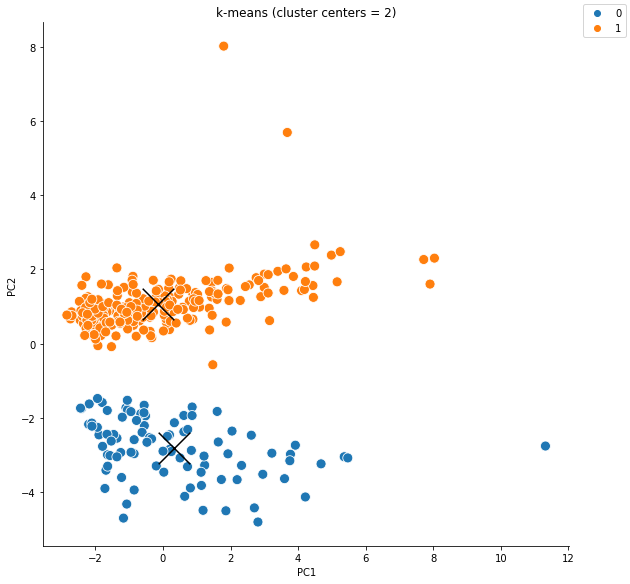

In [107]:
pp = sns.pairplot(data=secondaryDf,
                  y_vars=['PC2'],
                  x_vars=['PC1'],
                  kind = 'scatter', 
                 diag_kind='hist', corner = 'True', hue='Class', height=8,plot_kws={"s": 100}
                 )
leg_handles = pp._legend_data.values()
leg_labels = pp._legend_data.keys()
pp.fig.legend(handles=leg_handles, labels=leg_labels, loc='upper right', ncol=1)
pp._legend.remove() # remove existing legend
pp.set(xlabel='PC1',
       ylabel='PC2',
       title='k-means (cluster centers = 2)')

plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1], marker='x',s=1000, facecolors='black')

<IPython.core.display.Javascript object>


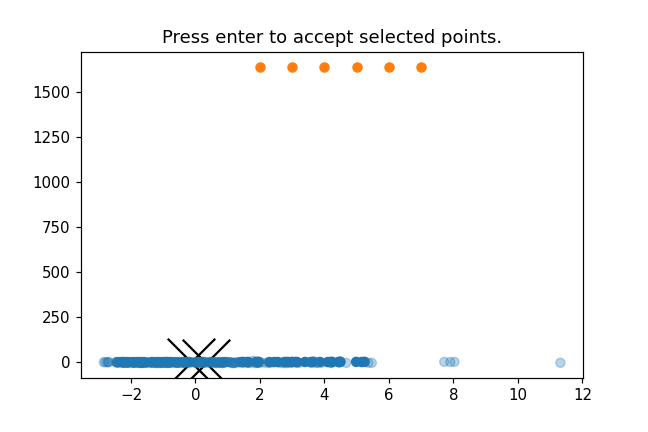

In [108]:
import numpy as np

from matplotlib.widgets import LassoSelector
from matplotlib.path import Path

%matplotlib notebook
class SelectFromCollection:
    """
    Select indices from a matplotlib collection using `LassoSelector`.

    Selected indices are saved in the `ind` attribute. This tool fades out the
    points that are not part of the selection (i.e., reduces their alpha
    values). If your collection has alpha < 1, this tool will permanently
    alter the alpha values.

    Note that this tool selects collection objects based on their *origins*
    (i.e., `offsets`).

    Parameters
    ----------
    ax : `~matplotlib.axes.Axes`
        Axes to interact with.
    collection : `matplotlib.collections.Collection` subclass
        Collection you want to select from.
    alpha_other : 0 <= float <= 1
        To highlight a selection, this tool sets all selected points to an
        alpha value of 1 and non-selected points to *alpha_other*.
    """

    def __init__(self, ax, collection, alpha_other=0.3):
        self.canvas = ax.figure.canvas
        self.collection = collection
        self.alpha_other = alpha_other

        self.xys = collection.get_offsets()
        self.Npts = len(self.xys)

        # Ensure that we have separate colors for each object
        self.fc = collection.get_facecolors()
        if len(self.fc) == 0:
            raise ValueError('Collection must have a facecolor')
        elif len(self.fc) == 1:
            self.fc = np.tile(self.fc, (self.Npts, 1))

        self.lasso = LassoSelector(ax, onselect=self.onselect)
        self.ind = []

    def onselect(self, verts):
        path = Path(verts)
        self.ind = np.nonzero(path.contains_points(self.xys))[0]
        self.fc[:, -1] = self.alpha_other
        self.fc[self.ind, -1] = 1
        self.collection.set_facecolors(self.fc)
        self.canvas.draw_idle()

    def disconnect(self):
        self.lasso.disconnect_events()
        self.fc[:, -1] = 1
        self.collection.set_facecolors(self.fc)
        self.canvas.draw_idle()



import matplotlib.pyplot as plt

# Fixing random state for reproducibility
np.random.seed(19680801)

data = np.random.rand(100, 2)

subplot_kw = dict(autoscale_on=True)
fig, ax = plt.subplots(subplot_kw=subplot_kw)

pts = ax.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1], marker='x',s=1000, facecolors='black')

pts = ax.scatter(secondaryDf['PC1'].to_numpy(),secondaryDf['PC2'].to_numpy())
selector = SelectFromCollection(ax, pts)

def accept(event):
    if event.key == "enter":
        print("Selected points:")
        print(selector.xys[selector.ind])
        selector.disconnect()
        ax.set_title("")
        fig.canvas.draw()

fig.canvas.mpl_connect("key_press_event", accept)
ax.set_title("Press enter to accept selected points.")

plt.show()

In [109]:
selector.ind

array([  1,   3,   5,  10,  19,  24,  26,  32,  35,  41,  42,  52,  54,
       120, 124, 153, 164, 166, 172, 189, 195, 202, 206, 209, 210, 213,
       215, 217, 222, 243, 245, 247, 255, 259, 260])

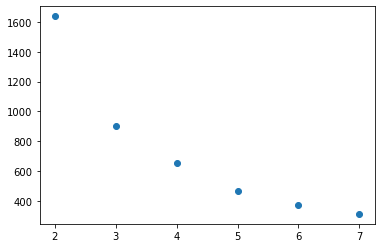

In [117]:
# inertia vs cluster centers plot
%matplotlib inline
inertia = []
cluster_number = []
for n_clusters in range(2,8):
    kmeans = KMeans(n_clusters = n_clusters, random_state = 42).fit(secondaryDf[['PC1','PC2']].to_numpy())
    inertia.append(kmeans.inertia_)
    cluster_number.append(n_clusters)
    
inertia = np.asarray(inertia)    
cluster_number = np.asarray(cluster_number)    
    
plt.scatter(cluster_number, inertia)

In [86]:
for i in range(3):
    secondaryDf['p' + str(i)] = 0
    
secondaryDf[['p0', 'p1']] = soft_clustering_weights(secondaryDf[['PC1','PC2']].to_numpy(), kmeans.cluster_centers_)

In [88]:
secondaryDf['confidence'] = np.max(secondaryDf[['p0', 'p1']].values, axis = 1)

In [90]:
secondaryDf['y']=y

In [91]:
df_color_converter = secondaryDf.groupby('Class', as_index = False)['labels'].mean().round().astype(int)
color_converter_dict = {}
for ind in df_color_converter.index:
    color_converter_dict[ind] = df_color_converter.loc[ind, 'labels']

KeyError: 'Column not found: labels'